In [ ]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.15.1 / PyTorch 2.6.0


In [2]:

BATCH_SIZE = 32

def load_datasets(partition_id, num_partitions: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [3]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MoonNet(nn.Module):
    """Returns both the representation (penultimate layer output) and classification"""
    def __init__(self) -> None:
        super(MoonNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        representation = x.clone()
        classification = self.fc3(x)
        return representation, classification

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    print(f"Started training moon")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    global_net.eval()

    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for batch in train_loader:
            x, target = batch["img"], batch["label"]
            x, target = x.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            # pro3 is the representation by the previous model (Line 16 of Algorithm 1)
            with torch.no_grad():
                pro2, _ = global_net(x)
                pro3, _ = previous_net(x)

            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to("cpu")
            logits /= temperature
            labels = torch.zeros(x.size(0)).to(DEVICE).long()

            # DEBUG
            print(f"XXXX Logits: {logits} Out: {out}")
            print(f"XXXX Labels: {labels} target: {target}")

            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)

            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)

            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )


def test_moon(net, testloader):
    """
    Evaluate the network on the entire test set.
    Same as the regular test, but using the MoonNet 
    (where the output is a tuple of (representation, classification) )
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            _, outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy




def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        for idx, (name, param) in enumerate(model.named_parameters()):
            if idx == trainable_layers or trainable_layers == -1:
                param.requires_grad = True
            else:
                param.requires_grad = False

In [4]:

NETWORK_LEN = len(Net().state_dict().keys())
EPOCHS = 2
NUM_PARTITIONS = 3
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 5
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 25


In [5]:
from flwr.common import NDArrays, Scalar

def get_evaluate_fn(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate

# Normal FedAvg

In [6]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_avg_result = {}
fed_avg_model_results = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_avg_model_results:
            expand_fed_avg_result= {**fed_avg_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_avg_result= {"global_loss": loss, "global_metrics": metrics}

        fed_avg_model_results[server_round] = expand_fed_avg_result

        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        

        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_size": total_size}
        else:
            expand_fed_avg_result= {"total_size": total_size}

        fed_avg_result[server_round] = expand_fed_avg_result


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_avg_result= {"total_loss": total_loss}

        fed_avg_result[server_round] = expand_fed_avg_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [7]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [ ]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07219561500549317, {'accuracy': 0.1041}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
2025-02-25 03:17:05,728	WARNING worker.py:1422 -- SIGTERM handler is not set because current thread is not the main thread.
2025-02-25 03:17:07,376	INFO worker.py:1752 -- Started a local Ray instance.
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     local variable 'future' referenced before assignment
ERROR :     local variable 'future' referenced before assignment
ERROR : 

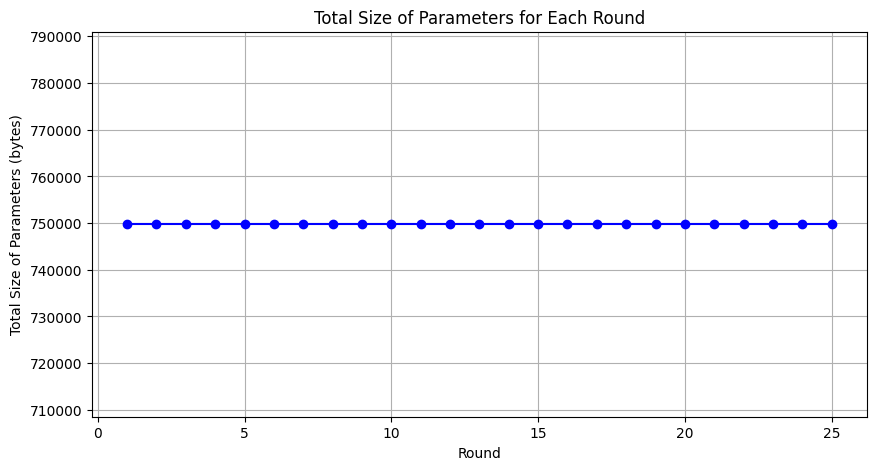

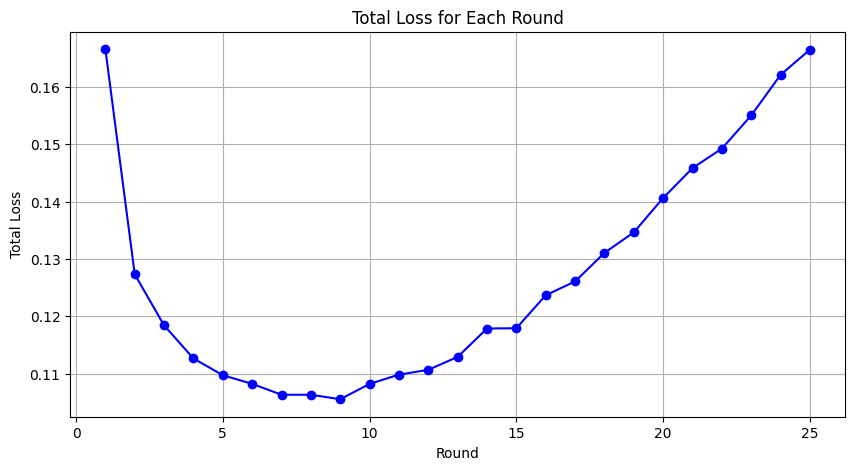

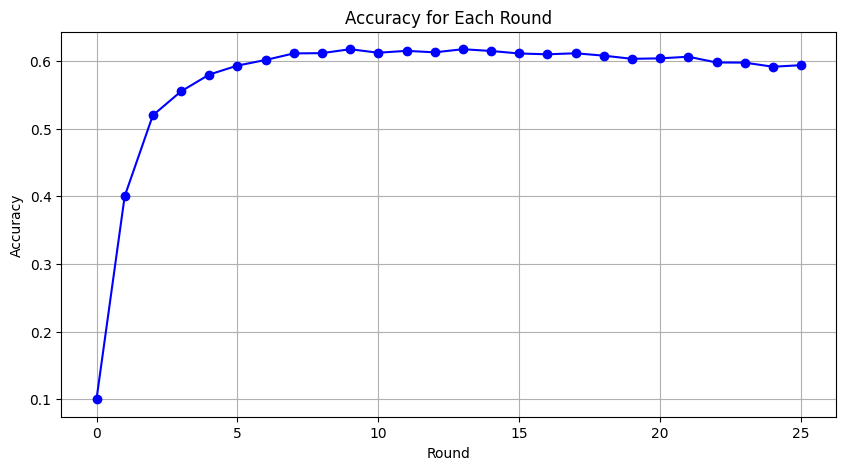

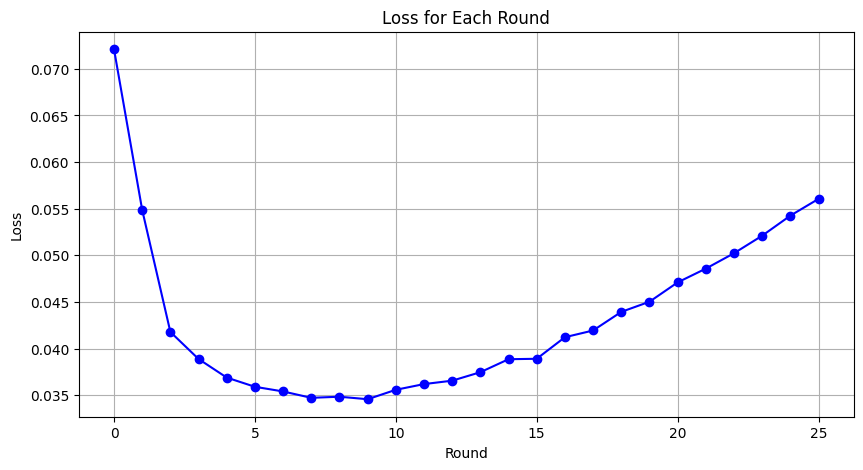

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.grid(True)

fed_avg_losses = [fed_avg_result[round]["total_loss"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.grid(True)

fed_avg_model_rounds = list(fed_avg_model_results.keys())

fed_avg_accuracies = [fed_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.grid(True)

fed_avg_global_losses = [fed_avg_model_results[round]["global_loss"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.grid(True)

# FedAvgPart Experiments

In [ ]:
from typing import Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

fed_part_avg_result = {}

fed_part_avg_model_results = {}


class FedPartAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

        self.layer_update_strategy = layer_update_strategy  # 'sequential' or 'cyclic'
        self.current_layer = 0  # Track which layer to update
        self.number_of_layers = None
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        self.layer_training_sequence = self.generate_layer_training_sequence()
        self.number_of_layers = len(ndarrays)

        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_avg_model_results:  
            expand_fed_part_avg_model_results= {**fed_part_avg_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_avg_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_avg_model_results[server_round] = expand_fed_part_avg_model_results
        
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_size"] = total_size
        else:
            fed_part_avg_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_avg_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    

In [ ]:
class FedAvgPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        freeze_layers(self.net, config["trainable_layers"])
        train(self.net, self.trainloader, epochs=EPOCHS)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedAvgPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [ ]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartAvg(
            evaluate_fn=evaluate_fn,
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07217735555171967, {'accuracy': 0.0968}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 2] fit, config: {'trainable_layers': -1}


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=86994) Epoch 1: train loss 0.05894485488533974, accuracy 0.3052055205520552
(ClientAppActor pid=86995) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=86994) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760
(ClientAppActor pid=86995) Epoch 2: train loss 0.04917217418551445, accuracy 0.4281107027675692 [repeated 5x across cluster]


INFO :      fit progress: (1, 0.05728812985420227, {'accuracy': 0.329}, 19.330080999992788)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=86994) [Client 2] evaluate, config: {}


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=86995) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86994) Epoch 1: train loss 0.048007529228925705, accuracy 0.43898597464936623
(ClientAppActor pid=86995) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86996) [Client 2] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=86995) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760
(ClientAppActor pid=86996) Epoch 2: train loss 0.04357944801449776, accuracy 0.4971497149714971 [repeated 5x across cluster]


INFO :      fit progress: (2, 0.04191807017326355, {'accuracy': 0.517}, 37.10905266701593)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=86994) [Client 1] evaluate, config: {}


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 2] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=86994) Epoch 1: train loss 0.04190751537680626, accuracy 0.5156015601560155
(ClientAppActor pid=86996) [Client 0] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86994) [Client 2] get_parameters
(ClientAppActor pid=86995) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
total size: 749760


INFO :      fit progress: (3, 0.03919881407022476, {'accuracy': 0.5532}, 54.7549014580145)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86995) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86995)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86995) Epoch 2: train loss 0.03983890637755394, accuracy 0.5386634665866646 [repeated 5x across cluster]
(ClientAppActor pid=86995) [Client 0] evaluate, config: {}
(ClientAppActor pid=86994) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86995) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86996) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=86995) Epoch 1: train loss 0.03836696594953537, accuracy 0.5604560456045604
(ClientAppActor pid=86996) [Client 2] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 1: train loss 0.03938785940408707, accuracy 0.5500637515937898
(ClientAppActor pid=86994) [Client 1] fit, config: {'trainable_layers': -1}


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86996) [Client 0] get_parameters
total size: 749760
(ClientAppActor pid=86994) Epoch 2: train loss 0.03675634413957596, accuracy 0.5798394959873997 [repeated 4x across cluster]


INFO :      fit progress: (4, 0.03763361920118332, {'accuracy': 0.5732}, 71.33557987501263)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=86994) [Client 0] evaluate, config: {}


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86995) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=86994) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86995) Epoch 1: train loss 0.03658323734998703, accuracy 0.5747393684842121
(ClientAppActor pid=86996) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86996) [Client 0] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=86995) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86996) Epoch 2: train loss 0.034334491938352585, accuracy 0.6123903097577439 [repeated 4x across cluster]
total size: 749760


INFO :      fit progress: (5, 0.03638779870867729, {'accuracy': 0.584}, 88.0302308750106)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=86994) [Client 0] evaluate, config: {}


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 0] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=86994) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86994) Epoch 2: train loss 0.03331086039543152, accuracy 0.6209120912091209
(ClientAppActor pid=86995) Epoch 1: train loss 0.03210841864347458, accuracy 0.6334383438343835
(ClientAppActor pid=86995) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86996) [Client 1] fit, config: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=86995) [Client 2] get_parameters
(ClientAppActor pid=86994) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 6453


INFO :      fit progress: (6, 0.03602470337152481, {'accuracy': 0.5932}, 103.4181080830167)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86995) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86995)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) Epoch 2: train loss 0.03248455002903938, accuracy 0.6301657541438536 [repeated 5x across cluster]
(ClientAppActor pid=86995) [Client 2] evaluate, config: {}
(ClientAppActor pid=86994) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 1] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=86996) [Client 1] get_parameters
(ClientAppActor pid=86996) [Client 0] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=86994) Epoch 1: train loss 0.032483309507369995, accuracy 0.6275406885172129
(ClientAppActor pid=86996) [Client 0] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 1: train loss 0.032703496515750885, accuracy 0.6338408460211505
(ClientAppActor pid=86994) [Client 1] get_parameters
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': 0}


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 6453


INFO :      fit progress: (7, 0.0360383847117424, {'accuracy': 0.5928}, 118.1111670419923)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 0] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.032624226063489914, accuracy 0.6315157878946974 [repeated 4x across cluster]
(ClientAppActor pid=86996) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 1] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=86995) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86994) Epoch 1: train loss 0.03203331306576729, accuracy 0.6345158628965725
(ClientAppActor pid=86995) Epoch 1: train loss 0.032257575541734695, accuracy 0.6387159678991975
(ClientAppActor pid=86994) [Client 1] get_parameters
(ClientAppActor pid=86995) [Client 0] fit, config: {'trainable_layers': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1125


INFO :      fit progress: (8, 0.03595497852563858, {'accuracy': 0.593}, 131.27558241700171)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86995) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86995)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86995) [Client 1] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.03140007331967354, accuracy 0.6423642364236424 [repeated 4x across cluster]
(ClientAppActor pid=86996) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86996) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86996) [Client 1] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=86995) Epoch 1: train loss 0.031410101801157, accuracy 0.6427392739273927
(ClientAppActor pid=86994) [Client 2] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 1: train loss 0.03202728182077408, accuracy 0.6343658591464787
(ClientAppActor pid=86995) [Client 2] get_parameters
(ClientAppActor pid=86994) [Client 0] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=86996) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1125


INFO :      fit progress: (9, 0.035948858880996706, {'accuracy': 0.5915}, 143.95326608300093)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 1] evaluate, config: {}
(ClientAppActor pid=86994) Epoch 2: train loss 0.0322466604411602, accuracy 0.6384159603990099 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86995) [Client 1] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=86994) [Client 0] get_parameters
(ClientAppActor pid=86994) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86995) Epoch 1: train loss 0.0325515940785408, accuracy 0.6291157278931974
(ClientAppActor pid=86994) Epoch 1: train loss 0.032668765634298325, accuracy 0.632340808520213
(ClientAppActor pid=86995) [Client 1] get_parameters
(ClientAppActor pid=86996) [Client 2] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853


INFO :      fit progress: (10, 0.035516638720035555, {'accuracy': 0.5977}, 156.8980570420099)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 0] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.0313333198428154, accuracy 0.6421392139213922 [repeated 4x across cluster]
(ClientAppActor pid=86995) [Client 2] evaluate, config: {}
(ClientAppActor pid=86996) [Client 2] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 0] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=86994) Epoch 1: train loss 0.032342586666345596, accuracy 0.6367659191479788
(ClientAppActor pid=86994) [Client 1] evaluate, config: {}
(ClientAppActor pid=86995) Epoch 1: train loss 0.03208988532423973, accuracy 0.633015825395635
(ClientAppActor pid=86994) [Client 0] get_parameters
(ClientAppActor pid=86995) [Client 1] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853


INFO :      fit progress: (11, 0.03561051838994026, {'accuracy': 0.5992}, 169.60100541700376)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=86994) [Client 2] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.030987659469246864, accuracy 0.6476897689768977 [repeated 4x across cluster]


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86996) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86994) [Client 1] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=86996) [Client 2] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=86995) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86994) Epoch 1: train loss 0.0312834233045578, accuracy 0.6417160429010725
(ClientAppActor pid=86996) Epoch 1: train loss 0.03056701086461544, accuracy 0.6503900390039004


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86994) [Client 1] get_parameters
(ClientAppActor pid=86995) [Client 0] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=86996) [Client 2] get_parameters
total size: 1245


INFO :      fit progress: (12, 0.03544194833040237, {'accuracy': 0.599}, 181.06254804201308)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 0] evaluate, config: {}
(ClientAppActor pid=86995) Epoch 2: train loss 0.031515080481767654, accuracy 0.644491112277807 [repeated 4x across cluster]
(ClientAppActor pid=86995) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=86995) [Client 0] get_parameters
(ClientAppActor pid=86994) Epoch 1: train loss 0.03151751309633255, accuracy 0.64441611040276
(ClientAppActor pid=86994) [Client 2] evaluate, config: {}
(ClientAppActor pid=86995) Epoch 1: train loss 0.030556047335267067, accuracy 0.6522652265226523
(ClientAppActor pid=86995) [Client 2] get_parameters
(ClientAppActor pid=86996) [Client 1] fit, config: {'trainable_layers': 3} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1245


INFO :      fit progress: (13, 0.03544565873146057, {'accuracy': 0.5998}, 193.26276387501275)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 0] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.03125528246164322, accuracy 0.6417160429010725 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86996) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86994) [Client 0] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=86996) [Client 1] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=86994) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86996) Epoch 1: train loss 0.032367922365665436, accuracy 0.6309907747693693
(ClientAppActor pid=86994) Epoch 1: train loss 0.032519057393074036, accuracy 0.6334658366459162


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86996) [Client 1] get_parameters
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=86994) [Client 0] get_parameters
total size: 577053


INFO :      fit progress: (14, 0.034868168884515764, {'accuracy': 0.6105}, 204.82341937499586)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 2] evaluate, config: {}
(ClientAppActor pid=86995) Epoch 2: train loss 0.029511207714676857, accuracy 0.6650915091509151 [repeated 4x across cluster]
(ClientAppActor pid=86995) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 0] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=86995) [Client 2] get_parameters
(ClientAppActor pid=86994) Epoch 1: train loss 0.031226282939314842, accuracy 0.6488412210305258
(ClientAppActor pid=86994) [Client 1] evaluate, config: {}
(ClientAppActor pid=86995) Epoch 1: train loss 0.031051771715283394, accuracy 0.6452411310282757
(ClientAppActor pid=86995) [Client 1] get_parameters
(ClientAppActor pid=86996) [Client 2] fit, config: {'trainable_layers': 4} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577053


INFO :      fit progress: (15, 0.03461759179830551, {'accuracy': 0.6106}, 216.48297079201438)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=86994) [Client 1] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.028240898624062538, accuracy 0.6788928892889289 [repeated 4x across cluster]


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86996) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=86994) [Client 1] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=86996) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86994) Epoch 1: train loss 0.028650466352701187, accuracy 0.6746418660466512
(ClientAppActor pid=86996) Epoch 1: train loss 0.028812531381845474, accuracy 0.67539188479712
(ClientAppActor pid=86995) [Client 2] get_parameters
(ClientAppActor pid=86996) [Client 0] fit, config: {'trainable_layers': 5}


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86994) [Client 1] get_parameters
total size: 2493


INFO :      fit progress: (16, 0.03446286562681198, {'accuracy': 0.6135}, 228.65884658301366)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86994) [Client 0] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.028703296557068825, accuracy 0.6769669241731043 [repeated 4x across cluster]
(ClientAppActor pid=86996) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 0] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=86996) [Client 0] get_parameters
(ClientAppActor pid=86994) Epoch 1: train loss 0.028680620715022087, accuracy 0.6773419335483387
(ClientAppActor pid=86995) [Client 2] evaluate, config: {}
(ClientAppActor pid=86995) Epoch 1: train loss 0.028538435697555542, accuracy 0.675916897922448
(ClientAppActor pid=86994) [Client 0] get_parameters
(ClientAppActor pid=86996) [Client 2] fit, config: {'trainable_layers': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2493


INFO :      fit progress: (17, 0.034454948353767396, {'accuracy': 0.614}, 242.24226724999608)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 0] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.02786238119006157, accuracy 0.6866936693669367 [repeated 4x across cluster]
(ClientAppActor pid=86996) [Client 2] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 1] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=86995) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86994) Epoch 1: train loss 0.028706775978207588, accuracy 0.672316807920198
(ClientAppActor pid=86995) Epoch 1: train loss 0.028796564787626266, accuracy 0.6764419110477762
(ClientAppActor pid=86994) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86996) [Client 2] fit, config: {'trainable_layers': 6} [repeated 2x across cluster]
total size: 122013


INFO :      fit progress: (18, 0.03465989452600479, {'accuracy': 0.616}, 255.4366129580012)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86995) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86995)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86995) [Client 2] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.02736787125468254, accuracy 0.6881938193819382 [repeated 4x across cluster]
(ClientAppActor pid=86994) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86996) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=86994) [Client 0] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=86995) Epoch 1: train loss 0.02756352350115776, accuracy 0.6863936393639364
(ClientAppActor pid=86996) [Client 0] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 1: train loss 0.02815913036465645, accuracy 0.6778669466736669
(ClientAppActor pid=86995) [Client 2] get_parameters
(ClientAppActor pid=86996) [Client 1] fit, config: {'trainable_layers': 6}


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86996) [Client 1] get_parameters
total size: 122013


INFO :      fit progress: (19, 0.034755465066432956, {'accuracy': 0.6167}, 268.45469495799625)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=86994) [Client 0] evaluate, config: {}
(ClientAppActor pid=86994) Epoch 2: train loss 0.027868513017892838, accuracy 0.6859671491787295 [repeated 4x across cluster]


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=86994) [Client 0] get_parameters
(ClientAppActor pid=86996) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86996) Epoch 1: train loss 0.027792682871222496, accuracy 0.6872421810545264
(ClientAppActor pid=86995) Epoch 1: train loss 0.027000993490219116, accuracy 0.6932193219321933
(ClientAppActor pid=86996) [Client 0] get_parameters
(ClientAppActor pid=86994) [Client 1] fit, config: {'trainable_layers': 7} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061


INFO :      fit progress: (20, 0.034722157555818554, {'accuracy': 0.617}, 280.127990375011)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 2] evaluate, config: {}
(ClientAppActor pid=86994) Epoch 2: train loss 0.02756839245557785, accuracy 0.6849171229280732 [repeated 4x across cluster]
(ClientAppActor pid=86995) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86996) [Client 1] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=86996) Epoch 1: train loss 0.027580376714468002, accuracy 0.6843921098027451
(ClientAppActor pid=86994) [Client 0] evaluate, config: {}
(ClientAppActor pid=86995) Epoch 1: train loss 0.02697478048503399, accuracy 0.6931443144314432
(ClientAppActor pid=86996) [Client 1] get_parameters
(ClientAppActor pid=86995) [Client 2] get_parameters
(ClientAppActor pid=86994) [Client 0] fit, config: {'trainable_layers': 7}


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061


INFO :      fit progress: (21, 0.034726178139448165, {'accuracy': 0.6167}, 292.10141733300406)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86995) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86995)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86995) [Client 1] evaluate, config: {}
(ClientAppActor pid=86994) Epoch 2: train loss 0.027748260647058487, accuracy 0.6872421810545264 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86996) [Client 1] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=86994) [Client 0] get_parameters
(ClientAppActor pid=86994) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86996) Epoch 1: train loss 0.02772160992026329, accuracy 0.6849171229280732
(ClientAppActor pid=86994) Epoch 1: train loss 0.027943605557084084, accuracy 0.6843171079276982


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86996) [Client 1] get_parameters
total size: 11133
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': 8} [repeated 2x across cluster]


INFO :      fit progress: (22, 0.03501886090636253, {'accuracy': 0.6152}, 303.72152120800456)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 2] evaluate, config: {}
(ClientAppActor pid=86994) Epoch 2: train loss 0.027793509885668755, accuracy 0.6865671641791045 [repeated 4x across cluster]
(ClientAppActor pid=86995) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86995) [Client 2] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=86994) [Client 0] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=86995) Epoch 1: train loss 0.02705305442214012, accuracy 0.6915691569156915
(ClientAppActor pid=86994) [Client 0] evaluate, config: {}
(ClientAppActor pid=86994) Epoch 1: train loss 0.02785404771566391, accuracy 0.6879171979299482


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86994) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86996) [Client 1] fit, config: {'trainable_layers': 8}
total size: 11133


INFO :      fit progress: (23, 0.035107517653703686, {'accuracy': 0.6161}, 315.2447860829998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=86994) [Client 1] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.02751425839960575, accuracy 0.6876921923048076 [repeated 4x across cluster]


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 1] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=86996) [Client 1] get_parameters
(ClientAppActor pid=86995) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=86994) Epoch 1: train loss 0.027430128306150436, accuracy 0.6884422110552764
(ClientAppActor pid=86996) Epoch 1: train loss 0.02684692293405533, accuracy 0.6943444344434443
(ClientAppActor pid=86994) [Client 1] get_parameters
(ClientAppActor pid=86995) [Client 0] fit, config: {'trainable_layers': 9} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1173


INFO :      fit progress: (24, 0.0350741849899292, {'accuracy': 0.6166}, 327.7805683329934)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=86994) [Client 2] evaluate, config: {}
(ClientAppActor pid=86995) Epoch 2: train loss 0.027597179636359215, accuracy 0.6884422110552764 [repeated 4x across cluster]
(ClientAppActor pid=86995) [Client 0] evaluate, config: {}


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86995) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=86994) [Client 2] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=86995) [Client 1] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=86994) Epoch 1: train loss 0.026813369244337082, accuracy 0.6948694869486949
(ClientAppActor pid=86996) [Client 1] evaluate, config: {}
(ClientAppActor pid=86995) Epoch 1: train loss 0.027410605922341347, accuracy 0.6892672316807921


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=86994) [Client 2] get_parameters
total size: 1173
(ClientAppActor pid=86996) [Client 0] fit, config: {'trainable_layers': 9}


INFO :      fit progress: (25, 0.035070203804969786, {'accuracy': 0.617}, 339.7918067080027)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=86996) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=86996)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=86996) [Client 0] evaluate, config: {}
(ClientAppActor pid=86996) Epoch 2: train loss 0.027609487995505333, accuracy 0.6882922073051826 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 342.79s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.057930123326874236
INFO :      		round 2: 0.04264377517310221
INFO :      		round 3: 0.0395998325950502
INFO :      		round 4: 0.03777137659735929
INFO :      		round 5: 0.036403042096491936
INFO :      		round 6: 0.03599704743635414
INFO :      		round 7: 0.035956468070370985
INFO :      		round 8: 0.03584370958765753
INFO :      		round 9: 0.03582850000877853
INFO :      		round 10: 0.035424072285743506
INFO :      		round 11: 0.03548208971997066
INFO :      		round 12: 0.03535438970348116
INFO :      		round 13: 0.035355322249196484
INFO :      		round 14: 0.03470567485268797
INFO :      		round 15: 0.03447767316258161
INFO :      		round 16: 0.034338527320146896
INFO :      		round 17: 0.03433657137364585
INFO :      		round 18: 0.034520840119228575
INFO :      		round 

(ClientAppActor pid=86996) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=86994) [Client 2] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=86994) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=86994)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


Text(0.5, 1.0, 'Loss for Each Round')

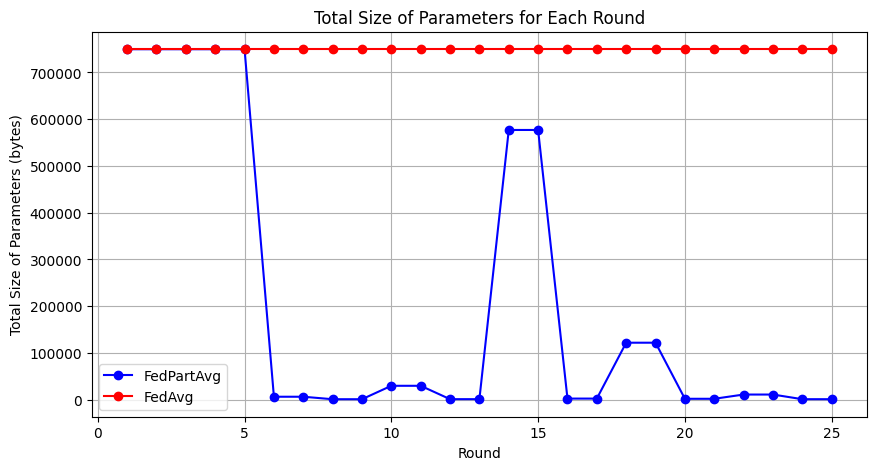

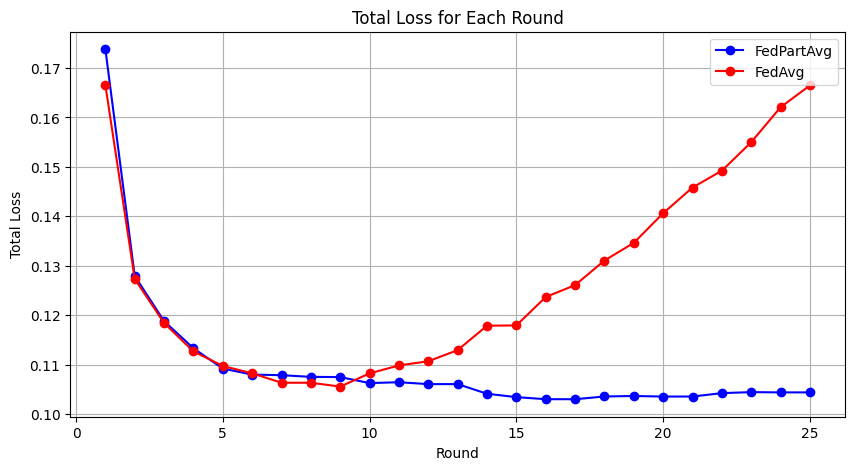

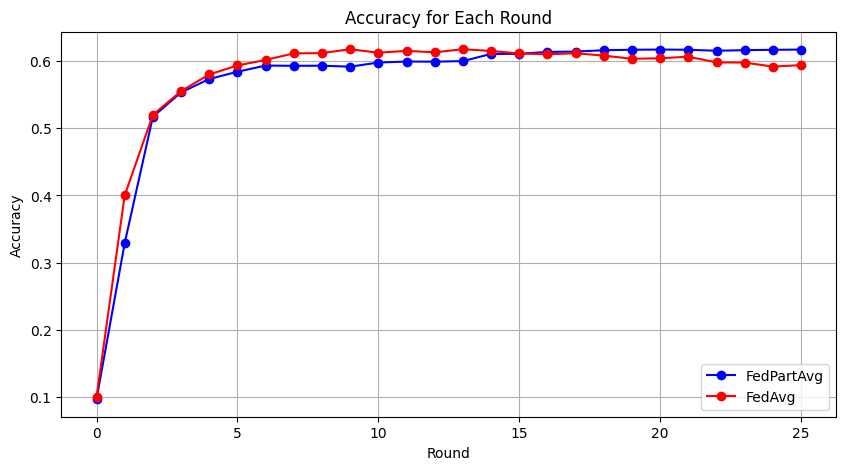

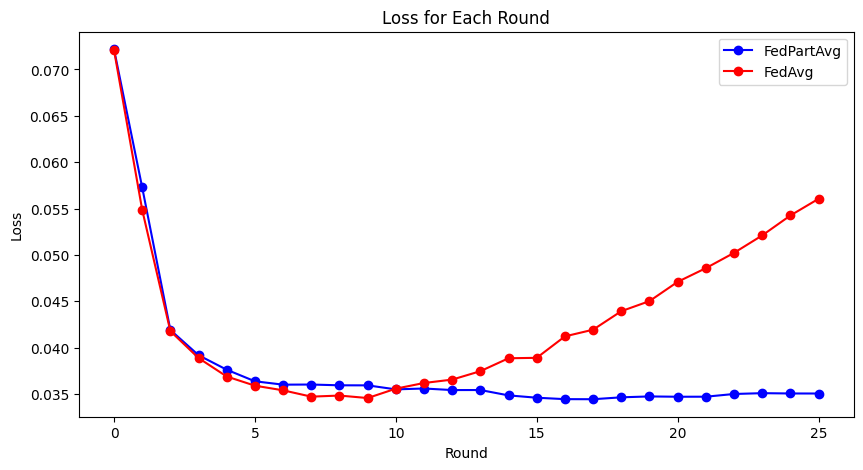

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total size of parameters for each round
fed_part_avg_rounds = list(fed_part_avg_result.keys())
fed_part_avg_sizes = [fed_part_avg_result[round]["total_size"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_losses = [fed_part_avg_result[round]["total_loss"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_avg_model_rounds = list(fed_part_avg_model_results.keys())
fed_part_avg_accuracies = [fed_part_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_global_losses = [fed_part_avg_model_results[round]["global_loss"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for Each Round')


# FedProxPart Experiments

In [ ]:
class FedProxPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        freeze_layers(self.net, config["trainable_layers"])
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [ ]:
fed_part_prox_result = {}

fed_part_prox_model_results = {}

class FedPartProx(FedPartAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_size"] = total_size
        else:
            fed_part_prox_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated
    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_prox_model_results:  
            expand_fed_part_prox_model_results= {**fed_part_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_prox_model_results[server_round] = expand_fed_part_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [ ]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07214949100017548, {'accuracy': 0.1002}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=58486) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=58486) Epoch 1: train loss 0.05707049369812012, accuracy 0.3213321332133213
(ClientAppActor pid=58487) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58488) [Client 1] get_parameters
total size: 749760
(ClientAppActor pid=58487) Epoch 2: train loss 0.048956792801618576, accuracy 0.4322358058951474 [repeated 5x across cluster]


INFO :      fit progress: (1, 0.05436111489534378, {'accuracy': 0.4002}, 19.566051917005097)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=58488) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=58487) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58487) Epoch 1: train loss 0.04780459776520729, accuracy 0.44618615465386635
(ClientAppActor pid=58486) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58487) [Client 1] get_parameters
(ClientAppActor pid=58487) Epoch 2: train loss 0.04369639232754707, accuracy 0.4958373959348984 [repeated 3x across cluster]
total size: 749760


INFO :      fit progress: (2, 0.042602294147014615, {'accuracy': 0.511}, 36.70638212500489)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=58488) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Feb 23 20:40:10 2025).
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) Epoch 2: train loss 0.04368296638131142, accuracy 0.500262506562664 [repeated 2x across cluster]


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=58486, ip=127.0.0.1, actor_id=42841c142ba72c9f3d4ad43001000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x107d6ade0>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/uoft-cs/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=58486, ip=127.0.0.1, actor_id=42841c142ba72c9f3d4ad43001000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x107d6ade0>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/flwr/simulation/ray_transport

(ClientAppActor pid=58487) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 2 results and 1 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=58487) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=58487) Epoch 1: train loss 0.042297717183828354, accuracy 0.5145128628215705
(ClientAppActor pid=58488) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=58487) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58488) Epoch 2: train loss 0.03918048366904259, accuracy 0.5498799879987999 [repeated 4x across cluster]
total size: 749760


INFO :      fit progress: (3, 0.039218665730953214, {'accuracy': 0.5534}, 83.37942283399752)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) Epoch 2: train loss 0.039707016199827194, accuracy 0.5400885022125553
(ClientAppActor pid=58487) Epoch 1: train loss 0.03869099169969559, accuracy 0.5536303630363036
(ClientAppActor pid=58488) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=58487) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58486) Epoch 2: train loss 0.0366257019340992, accuracy 0.5811145278631966 [repeated 5x across cluster]
total size: 749760


INFO :      fit progress: (4, 0.03773920437097549, {'accuracy': 0.5745}, 100.07098133399268)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.036741599440574646, accuracy 0.582689567239181
(ClientAppActor pid=58488) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58487) Epoch 2: train loss 0.0339285284280777, accuracy 0.6098859885988599 [repeated 4x across cluster]
total size: 749760


INFO :      fit progress: (5, 0.03686101281642914, {'accuracy': 0.5848}, 116.90832516699447)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58486) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) Epoch 2: train loss 0.03416699916124344, accuracy 0.6109652741318533
(ClientAppActor pid=58488) Epoch 1: train loss 0.03273190185427666, accuracy 0.6291157278931974
(ClientAppActor pid=58487) [Client 0] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58486) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 0] get_parameters
total size: 6453


INFO :      fit progress: (6, 0.03662795833349228, {'accuracy': 0.5906}, 132.72479591699084)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58486) Epoch 2: train loss 0.032205503433942795, accuracy 0.6320132013201321 [repeated 5x across cluster]
(ClientAppActor pid=58488) [Client 2] evaluate, config: {}
(ClientAppActor pid=58487) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=58486) [Client 2] get_parameters
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=58487) Epoch 1: train loss 0.03217136487364769, accuracy 0.6348634863486349
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58488) Epoch 1: train loss 0.032753556966781616, accuracy 0.6324908122703068
(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 6453


INFO :      fit progress: (7, 0.036501137471199034, {'accuracy': 0.5897}, 148.6708280419989)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.032575272023677826, accuracy 0.6297907447686192 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58487) Epoch 1: train loss 0.03235161677002907, accuracy 0.6324158103952598
(ClientAppActor pid=58488) Epoch 1: train loss 0.031906791031360626, accuracy 0.6368886888688869
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=58487) [Client 1] get_parameters
(ClientAppActor pid=58488) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1125


INFO :      fit progress: (8, 0.03648419537544251, {'accuracy': 0.5917}, 161.56365925000864)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.03245016559958458, accuracy 0.632940823520588 [repeated 4x across cluster]
(ClientAppActor pid=58488) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=58486) [Client 0] get_parameters
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=58488) Epoch 1: train loss 0.03234030678868294, accuracy 0.6324908122703068
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58487) Epoch 1: train loss 0.031883604824543, accuracy 0.6371887188718872
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1125


INFO :      fit progress: (9, 0.03648078180551529, {'accuracy': 0.5922}, 174.59692966699367)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.0324578583240509, accuracy 0.6337658441461037 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=58486) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.03275037556886673, accuracy 0.6312907822695567
(ClientAppActor pid=58487) Epoch 1: train loss 0.032215625047683716, accuracy 0.6350885088508851


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 2] get_parameters
total size: 29853


INFO :      fit progress: (10, 0.036300443863868714, {'accuracy': 0.594}, 187.0786389170098)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.03252822160720825, accuracy 0.6352658816470412 [repeated 4x across cluster]
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=58486) [Client 0] get_parameters
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=58487) Epoch 1: train loss 0.03193357214331627, accuracy 0.6353135313531353
(ClientAppActor pid=58488) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 1: train loss 0.03244197368621826, accuracy 0.628665716642916
(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853


INFO :      fit progress: (11, 0.036290678787231447, {'accuracy': 0.5951}, 199.63055520900525)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.032120946794748306, accuracy 0.6344408610215255 [repeated 4x across cluster]


(ClientAppActor pid=58486) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=58486) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Feb 23 20:40:10 2025).
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 1] evaluate, config: {}
(ClientAppActor pid=58488) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=58488) Epoch 1: train loss 0.03190399706363678, accuracy 0.6420910522763069
(ClientAppActor pid=58488) Epoch 2: train loss 0.03184960409998894, accuracy 0.6436660916522913
(ClientAppActor pid=58488) [Client 0] get_parameters


(ClientAppActor pid=58486) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=58486) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Feb 23 20:40:10 2025).
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=58486) Epoch 1: train loss 0.031674668192863464, accuracy 0.6400660016500412
(ClientAppActor pid=58486) Epoch 2: train loss 0.03164083510637283, accuracy 0.6414910372759319
(ClientAppActor pid=58486) [Client 1] get_parameters


(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=58487) Epoch 1: train loss 0.031223604455590248, accuracy 0.6475397539753975


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1245
(ClientAppActor pid=58487) Epoch 2: train loss 0.031170615926384926, accuracy 0.6466396639663966
(ClientAppActor pid=58487) [Client 2] get_parameters


INFO :      fit progress: (12, 0.03611619886159897, {'accuracy': 0.5966}, 240.9393897500122)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=58488) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=58488) Epoch 1: train loss 0.03163178265094757, accuracy 0.6432910822770569
(ClientAppActor pid=58486) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1245


INFO :      fit progress: (13, 0.036118165975809094, {'accuracy': 0.5954}, 254.02710408400162)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) Epoch 2: train loss 0.031153185293078423, accuracy 0.6471647164716472 [repeated 5x across cluster]
(ClientAppActor pid=58487) [Client 0] evaluate, config: {}
(ClientAppActor pid=58488) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=58488) Epoch 1: train loss 0.032810747623443604, accuracy 0.6271656791419785
(ClientAppActor pid=58486) [Client 2] evaluate, config: {}
(ClientAppActor pid=58487) Epoch 1: train loss 0.03234206885099411, accuracy 0.6323132313231323


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58488) [Client 0] get_parameters
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=58487) [Client 2] get_parameters
total size: 577053


INFO :      fit progress: (14, 0.035484035044908525, {'accuracy': 0.6056}, 266.36709833401255)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.03065778687596321, accuracy 0.6504912622815571 [repeated 4x across cluster]
(ClientAppActor pid=58486) [Client 1] get_parameters


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=58487) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.03145241364836693, accuracy 0.6413410335258382
(ClientAppActor pid=58487) Epoch 1: train loss 0.031672850251197815, accuracy 0.6426160654016351
(ClientAppActor pid=58486) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577053


INFO :      fit progress: (15, 0.035059994673728945, {'accuracy': 0.6096}, 279.6108799590147)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.02898053079843521, accuracy 0.6702670267026702 [repeated 4x across cluster]
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=58486) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=58487) Epoch 1: train loss 0.02885383926331997, accuracy 0.6760426042604261
(ClientAppActor pid=58488) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 1: train loss 0.029151491820812225, accuracy 0.6716417910447762
(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58486) [Client 1] get_parameters
total size: 2493


INFO :      fit progress: (16, 0.03489087723493576, {'accuracy': 0.6147}, 292.4423024590069)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58488) Epoch 2: train loss 0.029300609603524208, accuracy 0.6693917347933699 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=58488) [Client 0] get_parameters
(ClientAppActor pid=58488) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58487) Epoch 1: train loss 0.028695123270154, accuracy 0.6768676867686768
(ClientAppActor pid=58488) Epoch 1: train loss 0.02926493063569069, accuracy 0.670516762919073
(ClientAppActor pid=58487) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5} [repeated 2x across cluster]
total size: 2493


INFO :      fit progress: (17, 0.034886063706874845, {'accuracy': 0.6134}, 305.1299623340019)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.02895035222172737, accuracy 0.6744918622965574 [repeated 4x across cluster]
(ClientAppActor pid=58488) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=58487) Epoch 1: train loss 0.028866728767752647, accuracy 0.673042304230423
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 1: train loss 0.029414117336273193, accuracy 0.6672166804170104
(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=58486) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 122013


INFO :      fit progress: (18, 0.035213052386045454, {'accuracy': 0.6147}, 317.7020292500092)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 0] evaluate, config: {}
(ClientAppActor pid=58488) Epoch 2: train loss 0.028522366657853127, accuracy 0.6756168904222606 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.02869097702205181, accuracy 0.6727668191704793
(ClientAppActor pid=58487) Epoch 1: train loss 0.028986679390072823, accuracy 0.6725418135453386
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58486) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 122013


INFO :      fit progress: (19, 0.03517258603870869, {'accuracy': 0.6137}, 329.9216696670046)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.027952048927545547, accuracy 0.6826432643264326 [repeated 4x across cluster]
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58486) [Client 2] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58488) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=58488) Epoch 1: train loss 0.027851613238453865, accuracy 0.686018601860186
(ClientAppActor pid=58487) [Client 1] evaluate, config: {}
(ClientAppActor pid=58487) Epoch 1: train loss 0.028346411883831024, accuracy 0.6793669841746044
(ClientAppActor pid=58488) [Client 2] get_parameters
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061


INFO :      fit progress: (20, 0.03513677633404732, {'accuracy': 0.6138}, 342.52670441698865)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 1] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.028058186173439026, accuracy 0.6824420610515263 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=58488) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.02832283079624176, accuracy 0.6789169729243231
(ClientAppActor pid=58487) Epoch 1: train loss 0.027843503281474113, accuracy 0.6878187818781878
(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=58488) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061


INFO :      fit progress: (21, 0.03513615553975105, {'accuracy': 0.6131}, 355.02560520899715)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.02804466150701046, accuracy 0.6822170554263857 [repeated 4x across cluster]
(ClientAppActor pid=58488) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=58486) [Client 1] get_parameters
(ClientAppActor pid=58488) Epoch 1: train loss 0.028245985507965088, accuracy 0.6820670516762919
(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58487) Epoch 1: train loss 0.02850561961531639, accuracy 0.6773419335483387
(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 11133


INFO :      fit progress: (22, 0.0353413479089737, {'accuracy': 0.6133}, 366.99696349998703)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.027792956680059433, accuracy 0.6854935493549354 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58488) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=58486) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=58487) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58488) Epoch 1: train loss 0.028159353882074356, accuracy 0.6809420235505887
(ClientAppActor pid=58487) Epoch 1: train loss 0.028406687080860138, accuracy 0.6798169954248856


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58488) [Client 1] get_parameters
(ClientAppActor pid=58487) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=58487) [Client 0] get_parameters
total size: 11133


INFO :      fit progress: (23, 0.03542925624847412, {'accuracy': 0.6142}, 379.36877875000937)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.027783948928117752, accuracy 0.6872187218721872 [repeated 4x across cluster]
(ClientAppActor pid=58487) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58487) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=58486) [Client 2] get_parameters
(ClientAppActor pid=58487) Epoch 1: train loss 0.027947567403316498, accuracy 0.6831170779269482
(ClientAppActor pid=58486) [Client 0] evaluate, config: {}
(ClientAppActor pid=58488) Epoch 1: train loss 0.027683934196829796, accuracy 0.6879687968796879
(ClientAppActor pid=58487) [Client 1] get_parameters
(ClientAppActor pid=58486) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1173


INFO :      fit progress: (24, 0.035381616786122325, {'accuracy': 0.6153}, 391.7388833340083)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58487) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58487)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58487) [Client 2] evaluate, config: {}
(ClientAppActor pid=58486) Epoch 2: train loss 0.028174255043268204, accuracy 0.6824420610515263 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=58486) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=58486) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=58487) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=58488) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=58486) Epoch 1: train loss 0.0279292743653059, accuracy 0.6828170704267607
(ClientAppActor pid=58487) Epoch 1: train loss 0.02763141505420208, accuracy 0.6875187518751875


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=58487) [Client 2] get_parameters
(ClientAppActor pid=58488) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=58486) [Client 1] get_parameters
total size: 1173


INFO :      fit progress: (25, 0.03537553513050079, {'accuracy': 0.6142}, 403.8095760839933)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=58488) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=58488)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=58488) [Client 0] evaluate, config: {}
(ClientAppActor pid=58488) Epoch 2: train loss 0.028166603296995163, accuracy 0.6828170704267607 [repeated 4x across cluster]
(ClientAppActor pid=58487) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 406.72s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05487831842420197
INFO :      		round 2: 0.042843286102234285
INFO :      		round 3: 0.039378589676561604
INFO :      		round 4: 0.03777413790379971
INFO :      		round 5: 0.036866777615055184
INFO :      		round 6: 0.03661153610468721
INFO :      		round 7: 0.03652657389676564
INFO :      		round 8: 0.03652669200358975
INFO :      		round 9: 0.036532075491291935
INFO :      		round 10: 0.036454162340096484
INFO :      		round 11: 0.036378585182054356
INFO :      		round 12: 0.03615573628726804
INFO :      		round 13: 0.03615000750143226
INFO :      		round 14: 0.03574542513378285
INFO :      		round 15: 0.03527100471985671
INFO :      		round 16: 0.035103856974948625
INFO :      		round 17: 0.035102613699350374
INFO :      		round 18: 0.035456362962007666
INFO :      		rou

(ClientAppActor pid=58488) [Client 0] get_parameters
(ClientAppActor pid=58486) [Client 2] evaluate, config: {}


(ClientAppActor pid=58486) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=58486)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


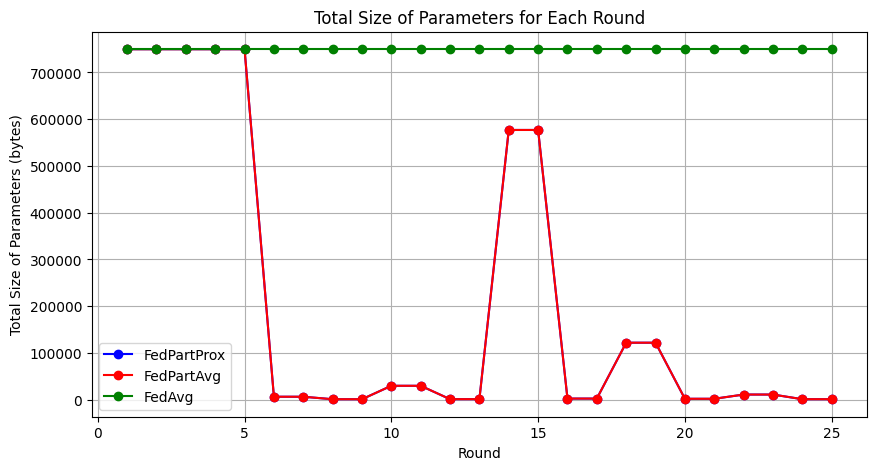

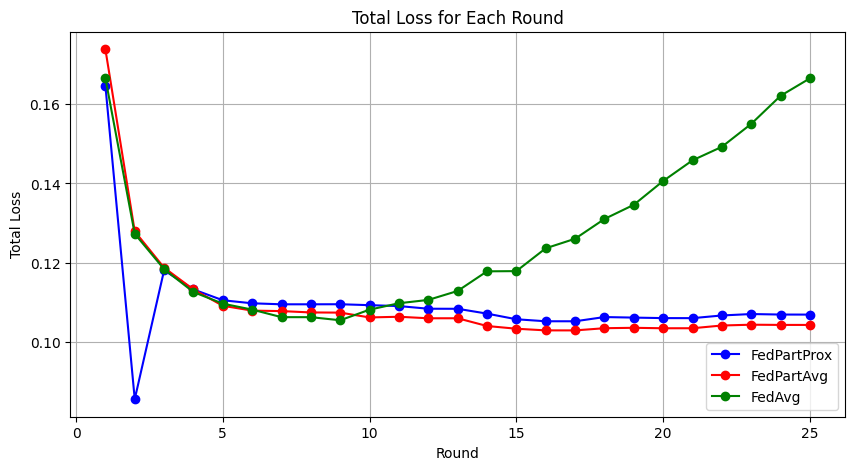

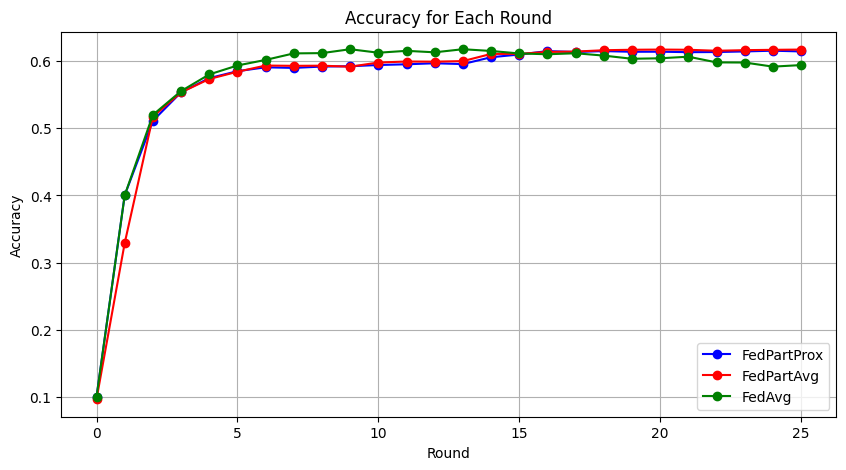

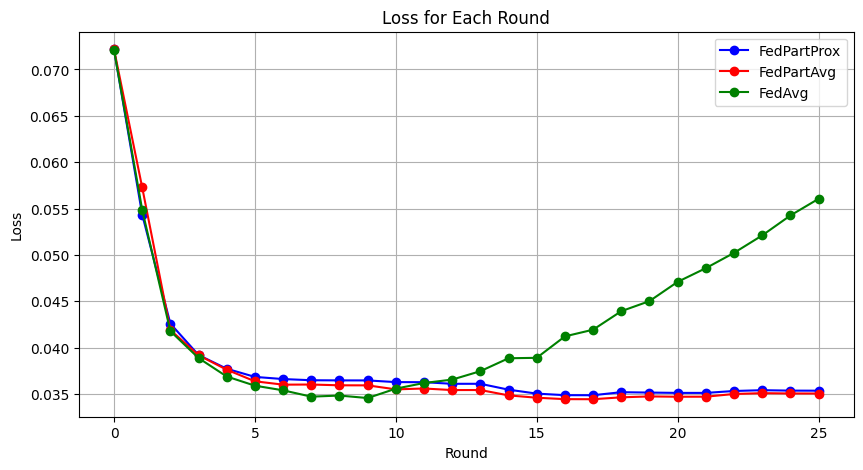

In [ ]:
fed_part_prox_rounds = list(fed_part_prox_result.keys())
fed_part_prox_sizes = [fed_part_prox_result[round]["total_size"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_losses = [fed_part_prox_result[round]["total_loss"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_prox_model_rounds = list(fed_part_prox_model_results.keys())
fed_part_prox_accuracies = [fed_part_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_prox_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_global_losses = [fed_part_prox_model_results[round]["global_loss"] for round in fed_part_prox_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.legend()
plt.grid(True)




# FedMoon Experiments:

In [13]:
import os

fed_avg_result = {}
fed_avg_model_results = {}

class FedMoonPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

def get_evaluate_fn_moon(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test_moon(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate

In [14]:
# Train FedMOON

# Reuse FedAvg logging dicts
fed_avg_result = {}
fed_avg_model_results = {}

_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn
        )
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07214627211093902, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34303) [Client 2] fit, config: {}
(ClientAppActor pid=34305) Started training moon
(ClientAppActor pid=34304) XXXX Logits: tensor([[2.0000e+00, 2.5731e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 1.3009e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 2.9767e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 4.3730e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 2.2843e-03],
(ClientAppActor pid=34304)         [2.0000e+00, 5.6838e-02],
(ClientAppActor pid=34304)         [2.0000e+00, 3.2881e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 2.2983e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 4.2067e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 3.3247e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 3.0217e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 3.4034e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 3.2972e-01],
(ClientAppActor pid=34304)         [2.0000e+00, 1.5070e-01],
(ClientAppActor pid=34304)    

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.04988380293846131, {'accuracy': 0.4415}, 26.124308499999984)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 0] evaluate, config: {}
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([0, 8, 6, 5, 6, 8, 1, 5, 0, 4, 8, 3, 6, 6, 8, 3, 3, 9, 6, 3]) [repeated 3x across cluster]
(ClientAppActor pid=34303) Epoch: 1 Loss: 2.280230 Loss1: 1.551309 Loss2: 0.728921 [repeated 3x across cluster]
(ClientAppActor pid=34303) XXXX Logits: tensor([[1.8995e+00, 9.2429e-04], [repeated 175x across cluster]
(ClientAppActor pid=34303)        grad_fn=<AddmmBackward0>) [repeated 15382x across cluster]
(ClientAppActor pid=34303)         [1.9507e+00, 2.4794e-05]], grad_fn=<DivBackward0>) Out: tensor([[ 1.0786e+00, -2.9429e+00, -1.1930e+00, -2.7637e+00, -1.2135e+00, [repeated 25x across cluster]
(ClientAppActor pid=34303)         [ 1.8261e+00, -1.5475e+00, -1.0627e+00, -3.7559e+00, -1.1687e+00, [repeated 1054x across cluster]
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34303) [Client 0] fit, config: {}
(ClientAppActor pid=34303) Started training moon
(ClientAppActor pid=34303) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.6620, 1.5454], [repeated 305x across cluster]
(ClientAppActor pid=34304)         3, 4, 3, 3, 0, 4, 6, 3]) [repeated 26902x across cluster]
(ClientAppActor pid=34304)         [1.7211, 1.6362]], grad_fn=<DivBackward0>) Out: tensor([[ 1.5527, -0.5726, -1.1184, -2.8832, -1.6748, -3.9713, -3.6630, -4.2813, [repeated 67x across cluster]
(ClientAppActor pid=34304)         [ 1.5992, -1.1629, -0.5618, -2.5931, -1.0395, -3.2807, -3.5099, -3.3753, [repeated 1933x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 305x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([7, 2, 0, 8, 4, 9, 7, 1, 7, 3, 8, 2, 9, 7, 6, 7, 0, 0, 7, 9

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.04419879533648491, {'accuracy': 0.4872}, 48.367782207999994)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 0] evaluate, config: {}
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.3753, 1.2547], [repeated 453x across cluster]
(ClientAppActor pid=34304)        grad_fn=<AddmmBackward0>) [repeated 39300x across cluster]
(ClientAppActor pid=34304)         [1.2930, 1.1719]], grad_fn=<DivBackward0>) Out: tensor([[ 6.9403e-01, -1.6725e+00, -6.0511e-01, -1.6745e+00, -5.5568e-01, [repeated 111x across cluster]
(ClientAppActor pid=34304)         [ 1.5823e+00, -1.2703e+00, -1.3534e+00, -1.9715e+00, -2.0249e+00, [repeated 3422x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 450x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([8, 1, 5, 8, 0, 7, 9, 4, 3, 0, 0, 4, 6, 3, 0, 4, 6, 9, 3, 4, 6, 3, 1, 3, [repeated 450x across cluster]
(ClientAppActor pid=34304)         [1.1698, 1.0245]], grad_fn=<DivBackward0>) Out: tensor([[-3.6123e

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34305) [Client 2] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34303) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.6911, 0.6778], [repeated 269x across cluster]
(ClientAppActor pid=34304)         2, 5, 4, 0, 0, 6, 7, 3]) [repeated 23311x across cluster]
(ClientAppActor pid=34304)         [1.6764, 0.3525]], grad_fn=<DivBackward0>) Out: tensor([[ 1.1572e+00,  1.1707e+00, -1.9500e+00, -3.3077e+00, -1.4129e+00, [repeated 67x across cluster]
(ClientAppActor pid=34304)         [ 1.3530e-01,  4.6309e-02, -8.6818e-01, -1.2317e+00, -6.9765e-01, [repeated 2121x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 269x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([8, 9, 1, 1, 3, 8, 4, 1, 1, 4, 3, 6, 4, 3, 2, 9, 3, 4, 3, 7, 4, 9, 1, 7, 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.040414111196994784, {'accuracy': 0.5403}, 71.25626162499998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] evaluate, config: {}
(ClientAppActor pid=34303) XXXX Logits: tensor([[1.2736, 0.3931], [repeated 382x across cluster]
(ClientAppActor pid=34303)        grad_fn=<AddmmBackward0>) [repeated 32863x across cluster]
(ClientAppActor pid=34303)         [1.3292, 0.4414]], grad_fn=<DivBackward0>) Out: tensor([[ 1.8806e+00, -2.3142e+00, -6.9912e-01, -2.5857e+00, -8.5975e-01, [repeated 102x across cluster]
(ClientAppActor pid=34303)         [ 1.4771e+00, -2.5531e+00, -6.8940e-01, -1.7358e+00, -1.7107e+00, [repeated 3164x across cluster]
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 379x across cluster]
(ClientAppActor pid=34303)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([1, 2, 1, 4, 2, 8, 6, 8, 9, 0, 8, 4, 1, 9, 7, 7, 8, 3, 4, 5, 9, 0, 0, 1, [repeated 379x across cluster]
(ClientAppActor pid=34303)         [1.2210, 0.2492]], grad_fn=<DivBackward0>) Out: tensor([[-3.0892e

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] fit, config: {}
(ClientAppActor pid=34303) Started training moon
(ClientAppActor pid=34303) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.5218, 0.1631], [repeated 315x across cluster]
(ClientAppActor pid=34304)         1, 4, 7, 6, 5, 5, 4, 7]) [repeated 26848x across cluster]
(ClientAppActor pid=34304)         [1.2855, 0.1377]], grad_fn=<DivBackward0>) Out: tensor([[ 3.2394e-01, -2.8919e+00,  4.1588e-01, -6.9724e-01, -7.9198e-01, [repeated 91x across cluster]
(ClientAppActor pid=34304)         [ 3.1312e-01,  1.3050e+00, -1.4097e+00, -2.7973e+00, -2.4661e+00, [repeated 2932x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 315x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([2, 9, 6, 9, 6, 7, 2, 2, 0, 9, 5, 1, 1, 5, 6, 3, 4, 4, 0, 2, 1, 2, 2, 2, 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.03858393315672874, {'accuracy': 0.5663}, 92.62280058300001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34305) [Client 0] evaluate, config: {}
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.4567, 0.1659], [repeated 347x across cluster]
(ClientAppActor pid=34305)           -2.0387,  -0.6709,   1.5166]], grad_fn=<AddmmBackward0>) [repeated 29377x across cluster]
(ClientAppActor pid=34305)         [1.5971, 0.3145]], grad_fn=<DivBackward0>) Out: tensor([[ -6.3030,  -6.7077,  -0.4009,  -0.7821,   2.1082,  -2.1963,   1.8727, [repeated 113x across cluster]
(ClientAppActor pid=34305)         [  0.5011,   0.5847,  -2.2646,  -2.5806,  -1.1454,  -3.3500,  -3.7003, [repeated 3340x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 344x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([1, 4, 9, 7, 1, 4, 2, 0, 0, 9, 9, 3, 7, 9, 8, 9, 4, 4, 4, 8, 2, 1, 4, 7, [repeated 344x across cluster]
(ClientAppActor pid=34305)         [1.5703, 0.1673]], gr

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34303) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.4935, 0.2436], [repeated 302x across cluster]
(ClientAppActor pid=34304)         7, 9, 6, 8, 4, 5, 6, 7]) [repeated 26028x across cluster]
(ClientAppActor pid=34304)         [1.5597, 0.4958]], grad_fn=<DivBackward0>) Out: tensor([[ 7.5146e-01, -1.0396e+00, -7.6804e-01, -1.5459e+00, -1.4448e-01, [repeated 68x across cluster]
(ClientAppActor pid=34304)         [ 1.1494e+00, -2.3397e+00, -5.5509e-01, -8.5286e-01, -2.6394e-01, [repeated 2535x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 302x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([9, 0, 4, 8, 9, 3, 8, 8, 1, 3, 8, 4, 0, 9, 3, 8, 5, 3, 0, 4, 0, 5, 3, 2, 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 0.03812906987071037, {'accuracy': 0.5722}, 113.971873458)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34305) [Client 0] evaluate, config: {}
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([2, 7, 5, 8, 5, 4, 5, 8, 2, 7, 6, 3, 3, 9, 9, 8, 3, 0, 0, 5]) [repeated 3x across cluster]
(ClientAppActor pid=34305) Epoch: 1 Loss: 2.440881 Loss1: 1.114261 Loss2: 1.326621 [repeated 3x across cluster]
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.1879, 0.2156], [repeated 345x across cluster]
(ClientAppActor pid=34305)          -0.5706, -2.0726]], grad_fn=<AddmmBackward0>) [repeated 28995x across cluster]
(ClientAppActor pid=34305)         [1.2840, 0.1266]], grad_fn=<DivBackward0>) Out: tensor([[ 2.8724e+00,  2.1190e-01, -8.4504e-01, -2.8610e+00, -1.9975e+00, [repeated 113x across cluster]
(ClientAppActor pid=34305)         [ 1.4982, -1.1117, -0.2759, -2.2880,  0.1790, -2.3789, -1.9986, -0.2114, [repeated 3525x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0,

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34303) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.5757, 0.4694], [repeated 357x across cluster]
(ClientAppActor pid=34304)         4, 9, 6, 1, 7, 4, 2, 9]) [repeated 30509x across cluster]
(ClientAppActor pid=34304)         [1.3814, 0.5897]], grad_fn=<DivBackward0>) Out: tensor([[ 1.9333e-01, -3.3503e+00, -1.6852e+00,  5.5282e-01, -2.1538e+00, [repeated 94x across cluster]
(ClientAppActor pid=34304)         [ 4.0073e-02, -5.4965e+00, -8.3498e-01,  1.2212e+00, -1.7671e+00, [repeated 3264x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 357x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([2, 7, 4, 8, 8, 3, 6, 0, 4, 1, 0, 1, 5, 0, 2, 0, 2, 4, 3, 7, 5, 4, 2, 2, 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (6, 0.03763797634840012, {'accuracy': 0.5803}, 135.12713925000003)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] evaluate, config: {}
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([1, 3, 3, 1, 2, 3, 8, 0, 8, 5, 2, 2, 5, 0, 9, 0, 3, 7, 6, 8, 1]) [repeated 3x across cluster]
(ClientAppActor pid=34303) Epoch: 1 Loss: 2.594700 Loss1: 1.085087 Loss2: 1.509613 [repeated 3x across cluster]
(ClientAppActor pid=34303) XXXX Logits: tensor([[1.5040, 0.3510], [repeated 328x across cluster]
(ClientAppActor pid=34303)          -1.7706,  0.1229]], grad_fn=<AddmmBackward0>) [repeated 27317x across cluster]
(ClientAppActor pid=34305)         [1.6219, 0.5693]], grad_fn=<DivBackward0>) Out: tensor([[ 1.3785e+00,  2.6366e+00, -2.6640e+00, -4.2130e+00, -2.9952e+00, [repeated 118x across cluster]
(ClientAppActor pid=34303)         [ 1.2562, -1.1678, -1.7570, -2.0820, -2.1706, -2.7117, -3.6470, -2.4478, [repeated 3610x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0,

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34303) [Client 1] fit, config: {}
(ClientAppActor pid=34303) Started training moon
(ClientAppActor pid=34305) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.5226, 0.1180], [repeated 376x across cluster]
(ClientAppActor pid=34304)         4, 4, 0, 7, 9, 8, 4, 5]) [repeated 32236x across cluster]
(ClientAppActor pid=34304)         [1.5350, 0.1628]], grad_fn=<DivBackward0>) Out: tensor([[ 3.1330e-01, -4.3934e+00, -2.8598e-02, -5.3962e-01, -1.5295e+00, [repeated 124x across cluster]
(ClientAppActor pid=34304)         [ 8.9214e-02,  5.4138e-01, -1.7553e+00, -1.5149e+00, -1.0826e+00, [repeated 3343x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 376x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([3, 7, 2, 2, 5, 6, 5, 3, 9, 8, 6, 8, 1, 2, 9, 5, 8, 6, 1, 3, 4, 3, 2, 3,

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (7, 0.03754489771723747, {'accuracy': 0.591}, 158.077443167)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 0] evaluate, config: {}
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([3, 2, 8, 7, 9, 3, 3, 3, 3, 6, 4, 5, 6, 6, 2, 9, 1, 8, 1, 9]) [repeated 3x across cluster]
(ClientAppActor pid=34305) Epoch: 1 Loss: 2.794697 Loss1: 1.050562 Loss2: 1.744135 [repeated 3x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.4960, 0.3603], [repeated 271x across cluster]
(ClientAppActor pid=34304)            0.7012,  -3.4945,   1.1356]], grad_fn=<AddmmBackward0>) [repeated 22351x across cluster]
(ClientAppActor pid=34304)         [1.5038, 0.1697]], grad_fn=<DivBackward0>) Out: tensor([[ -3.6207,  -7.2332,  -2.4757,   3.1506,  -1.2842,   4.0773,  -4.9816, [repeated 111x across cluster]
(ClientAppActor pid=34304)         [ -0.5941,  -0.1274,  -2.6457,  -1.7097,  -2.0260,  -1.3991,  -1.7712, [repeated 3174x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0,

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34305) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.2708, 0.3271], [repeated 327x across cluster]
(ClientAppActor pid=34304)         0, 1, 7, 5, 1, 0, 2, 5]) [repeated 27868x across cluster]
(ClientAppActor pid=34304)         [1.8547, 0.6235]], grad_fn=<DivBackward0>) Out: tensor([[ -0.9811,   2.9076,  -1.5601,  -2.8690,  -3.8042,  -3.0569,  -1.8463, [repeated 101x across cluster]
(ClientAppActor pid=34304)         [ -0.8335,  -4.1421,  -0.3272,   0.3797,  -0.7165,   1.0904,  -1.8760, [repeated 3066x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 327x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([1, 3, 0, 6, 5, 9, 8, 5, 6, 7, 8, 4, 4, 5, 9, 6, 5, 6, 8, 3, 4

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (8, 0.03753824909925461, {'accuracy': 0.5925}, 180.07488008299998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34303) [Client 1] evaluate, config: {}
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.6758, 0.3928], [repeated 433x across cluster]
(ClientAppActor pid=34305)          -3.1065,  1.6400]], grad_fn=<AddmmBackward0>) [repeated 35133x across cluster]
(ClientAppActor pid=34305)         [1.8756, 1.3634]], grad_fn=<DivBackward0>) Out: tensor([[ -3.3303,  -5.9679,  -0.7288,   2.0717,  -1.6633,   1.4900,  -3.1477, [repeated 194x across cluster]
(ClientAppActor pid=34305)         [ 0.1400, -0.2143, -3.7642, -3.2025, -4.2950, -4.7222, -4.8561, -4.2906, [repeated 5732x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 430x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([9, 2, 0, 4, 6, 8, 3, 0, 3, 0, 1, 6, 6, 7, 0, 5, 0, 3, 9, 0, 1, 6, 3, 1, [repeated 430x across cluster]
(ClientAppActor pid=34305)         [1.3005, 0.6104]], grad_fn=<Div

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34305) [Client 0] fit, config: {}
(ClientAppActor pid=34305) Started training moon
(ClientAppActor pid=34305) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.6909, 0.9206], [repeated 108x across cluster]
(ClientAppActor pid=34305)         0, 2, 3, 9, 0, 1, 0, 6]) [repeated 9264x across cluster]
(ClientAppActor pid=34305)         [1.3779, 0.3035]], grad_fn=<DivBackward0>) Out: tensor([[ -2.0023,   6.1541,  -3.0223,  -8.2110,  -6.9095,  -7.4242,  -3.4745, [repeated 28x across cluster]
(ClientAppActor pid=34305)         [ 2.5681e+00, -2.6888e+00, -8.0779e-01, -3.2102e+00, -3.4184e+00, [repeated 947x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 108x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([2, 9, 0, 5, 8, 6, 2, 0, 4, 5, 5, 3, 6, 5, 0, 9, 9, 0, 4, 2, 5, 8, 5, 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([3, 3, 4, 4, 3, 9, 5, 1, 9, 2, 1, 0, 6, 5, 0, 1, 1, 8, 2, 4])
(ClientAppActor pid=34303) Epoch: 1 Loss: 2.589077 Loss1: 0.938168 Loss2: 1.650909


INFO :      fit progress: (9, 0.038227004241943356, {'accuracy': 0.59}, 206.71172475000003)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34303) [Client 1] evaluate, config: {}
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.5253, 0.7669], [repeated 174x across cluster]
(ClientAppActor pid=34304)        grad_fn=<AddmmBackward0>) [repeated 14126x across cluster]
(ClientAppActor pid=34304)         [1.5739, 0.5574]], grad_fn=<DivBackward0>) Out: tensor([[  1.0239,  -2.8137,  -2.8857,  -4.1409,  -3.5973,  -6.3189,  -7.4247, [repeated 82x across cluster]
(ClientAppActor pid=34304)         [ 1.3002e+00, -3.7505e+00, -4.3563e+00, -4.2583e+00, -3.4448e+00, [repeated 2277x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 172x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([8, 5, 4, 7, 7, 0, 0, 8, 4, 1, 4, 4, 2, 3, 2, 4, 9, 3, 7, 7, 9, 8, 9, 9, [repeated 172x across cluster]
(ClientAppActor pid=34304)         [1.4747, 0.8323]], grad_fn=<DivBackward0>) Out: tensor([[-2.2

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 0] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([1, 5, 2, 4, 0, 4, 4, 8, 8, 9, 4, 3, 8, 9, 0, 7, 2, 7, 8, 5, 6])
(ClientAppActor pid=34304) Epoch: 1 Loss: 2.795265 Loss1: 0.980544 Loss2: 1.814721
(ClientAppActor pid=34304) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.5281, 0.3322], [repeated 289x across cluster]
(ClientAppActor pid=34304)         2, 9, 0, 2, 2, 2, 9, 7]) [repeated 24147x across cluster]
(ClientAppActor pid=34304)         [0.7530, 0.1033]], grad_fn=<DivBackward0>) Out: tensor([[ 9.7130e-01, -3.0581e-01, -3.9501e+00, -2.8434e+00, -6.7890e+00, [repeated 100x across cluster]
(ClientAppActor pid=34304)         [ 3.6330e-01, -6.3109e-01, -2.6005e-01, -1.1000e+00, -1.2920e+00, [repeated 3199x across cluster]
(ClientAppActor pid=343

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (10, 0.03897754185199737, {'accuracy': 0.58}, 233.36444729200002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] evaluate, config: {}
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([5, 8, 5, 9, 6, 0, 5, 1, 3, 3, 9, 1, 5, 1, 6, 8, 1, 8, 5, 5]) [repeated 3x across cluster]
(ClientAppActor pid=34303) Epoch: 1 Loss: 2.626299 Loss1: 0.926068 Loss2: 1.700231 [repeated 3x across cluster]
(ClientAppActor pid=34303) XXXX Logits: tensor([[1.1296, 0.3126], [repeated 378x across cluster]
(ClientAppActor pid=34303)           -1.8876,  -6.1341,  -5.7013]], grad_fn=<AddmmBackward0>) [repeated 29850x across cluster]
(ClientAppActor pid=34303)         [1.5018, 0.3462]], grad_fn=<DivBackward0>) Out: tensor([[ -5.7780,  -6.6257,  -1.6206,  -0.1386,  -2.6503,   2.4180,  -4.1104, [repeated 192x across cluster]
(ClientAppActor pid=34303)         [ -5.3771,  -7.4132,  -1.2622,   0.1050,  -2.8399,   3.5761,  -1.3355, [repeated 5795x across cluster]
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0,

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34305) [Client 0] fit, config: {}
(ClientAppActor pid=34305) Started training moon
(ClientAppActor pid=34305) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.7633, 0.5209], [repeated 356x across cluster]
(ClientAppActor pid=34304)         7, 0, 5, 6, 3, 1, 0, 6]) [repeated 29784x across cluster]
(ClientAppActor pid=34304)         [1.5963, 0.3070]], grad_fn=<DivBackward0>) Out: tensor([[ -9.5608, -12.1162,  -4.8570,   1.2861,  -6.2038,  -2.4925,   6.6305, [repeated 119x across cluster]
(ClientAppActor pid=34304)         [ 1.3425,  0.0990, -1.0661, -2.1377, -1.4678, -3.9640, -2.1316, -3.6467, [repeated 3897x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 356x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([5, 1, 7, 4, 8, 2, 2, 8, 5, 0, 4, 1, 3, 5, 9, 9, 1, 4, 0, 4,

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (11, 0.038255768442153934, {'accuracy': 0.5859}, 258.043446125)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34303) [Client 1] evaluate, config: {}
(ClientAppActor pid=34303) XXXX Logits: tensor([[1.2260, 0.6608], [repeated 707x across cluster]
(ClientAppActor pid=34303)        grad_fn=<AddmmBackward0>) [repeated 56512x across cluster]
(ClientAppActor pid=34303)         [1.1747, 0.7586]], grad_fn=<DivBackward0>) Out: tensor([[ 1.1630e+00, -5.3207e+00, -1.1255e+00, -2.5140e+00, -3.1318e+00, [repeated 326x across cluster]
(ClientAppActor pid=34303)         [ 3.5894e-01,  2.5761e+00, -1.6470e+00, -4.3441e+00, -3.4482e+00, [repeated 10275x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 704x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([9, 0, 7, 6, 1, 4, 0, 2, 9, 8, 3, 8, 0, 1, 3, 7, 4, 6, 0, 5, 6, 1, 5, 5, [repeated 704x across cluster]
(ClientAppActor pid=34304)         [1.0577, 0.5084]], grad_fn=<DivBackward0>) Out: tensor([[-3.3023

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34305) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.7435, 0.8094], [repeated 285x across cluster]
(ClientAppActor pid=34304)         2, 7, 6, 9, 1, 8, 8, 4]) [repeated 23412x across cluster]
(ClientAppActor pid=34304)         [1.6417, 0.0032]], grad_fn=<DivBackward0>) Out: tensor([[ 1.2974e+00, -3.0205e+00, -3.7660e-01, -1.9962e+00, -1.4244e+00, [repeated 118x across cluster]
(ClientAppActor pid=34304)         [ 4.1582e-01, -2.0164e+00, -6.0442e+00, -5.7857e+00, -6.6067e+00, [repeated 3558x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 285x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([5, 3, 1, 1, 7, 2, 4, 7, 3, 0, 2, 1, 8, 8, 6, 7, 9, 1, 6, 9, 9, 5, 8, 3,

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (12, 0.038685343194007876, {'accuracy': 0.5828}, 281.874846458)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] evaluate, config: {}
(ClientAppActor pid=34305) XXXX Logits: tensor([[0.7426, 0.4030], [repeated 593x across cluster]
(ClientAppActor pid=34305)        grad_fn=<AddmmBackward0>) [repeated 46996x across cluster]
(ClientAppActor pid=34305)         [1.6730, 1.2882]], grad_fn=<DivBackward0>) Out: tensor([[ 2.0579e+00, -2.2657e+00,  7.6309e-01, -3.7262e+00, -8.5302e-01, [repeated 282x across cluster]
(ClientAppActor pid=34305)         [ 6.3525e-01, -1.9080e+00, -7.8860e-01, -1.0051e+00, -2.3189e-01, [repeated 8989x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 590x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([9, 7, 9, 3, 7, 3, 2, 8, 2, 4, 5, 8, 4, 7, 4, 0, 4, 8, 0, 7, 2, 8, 4, 7, [repeated 590x across cluster]
(ClientAppActor pid=34305)         [1.2524, 0.8514]], grad_fn=<DivBackward0>) Out: tensor([[-4.0934e

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34305) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.3816, 1.0849], [repeated 300x across cluster]
(ClientAppActor pid=34304)         7, 5, 2, 9, 0, 7, 9, 9]) [repeated 24016x across cluster]
(ClientAppActor pid=34304)         [1.5818, 1.3674]], grad_fn=<DivBackward0>) Out: tensor([[  2.9912,  -2.6525,  -0.4740,  -2.9785,  -1.4475,  -5.4802,  -4.8048, [repeated 136x across cluster]
(ClientAppActor pid=34304)         [ -0.2168,   1.9136,  -7.3519,  -9.5556,  -7.0751, -10.8550, -11.2043, [repeated 4346x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 300x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([0, 0, 6, 2, 4, 1, 8, 7, 6, 0, 6, 5, 2, 5, 1, 9, 0, 4, 7, 8, 0

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (13, 0.0381626130759716, {'accuracy': 0.5942}, 305.12246337500005)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] evaluate, config: {}
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.6992, 0.6683], [repeated 560x across cluster]
(ClientAppActor pid=34305)           -4.7705,  -2.8527,  -3.8334]], grad_fn=<AddmmBackward0>) [repeated 44676x across cluster]
(ClientAppActor pid=34305)         [1.6627, 0.5423]], grad_fn=<DivBackward0>) Out: tensor([[ -6.6797,  -3.7866,  -2.1514,  -1.7405,  -3.3089,  -1.5538,   5.1439, [repeated 267x across cluster]
(ClientAppActor pid=34305)         [  1.1530,  -5.2678,  -3.1271,  -5.1264,  -2.0585,  -6.4928,  -8.1540, [repeated 8197x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 557x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([5, 6, 2, 5, 2, 2, 5, 7, 8, 3, 1, 7, 7, 0, 9, 9, 8, 0, 9, 5, 3, 5, 9, 0, [repeated 557x across cluster]
(ClientAppActor pid=34305)         [1.3259, 0.0983]], gr

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34305) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.8542, 1.7719], [repeated 273x across cluster]
(ClientAppActor pid=34304)         5, 5, 9, 8, 1, 6, 7, 0]) [repeated 21512x across cluster]
(ClientAppActor pid=34304)         [1.8586, 1.2022]], grad_fn=<DivBackward0>) Out: tensor([[ 1.1740e-01, -2.5223e+00, -8.5002e-01, -2.9916e+00, -7.0860e-01, [repeated 145x across cluster]
(ClientAppActor pid=34304)         [ 4.2415e+00, -5.3659e+00, -5.2884e-01, -4.1851e+00, -4.1076e+00, [repeated 4297x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 273x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([7, 7, 4, 2, 8, 7, 8, 4, 5, 7, 8, 3, 8, 8, 9, 3, 9, 7, 4, 3, 2, 8, 0, 2,

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (14, 0.038390761023759844, {'accuracy': 0.5867}, 329.342408375)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] evaluate, config: {}
(ClientAppActor pid=34303) XXXX Logits: tensor([[0.9486, 0.2627], [repeated 619x across cluster]
(ClientAppActor pid=34303)        grad_fn=<AddmmBackward0>) [repeated 48906x across cluster]
(ClientAppActor pid=34303)         [1.4904, 0.4339]], grad_fn=<DivBackward0>) Out: tensor([[ -3.5251,  -5.9500,  -1.4131,  -0.2224,   0.7830,   0.2286,  -2.3750, [repeated 316x across cluster]
(ClientAppActor pid=34303)         [ 7.3639e-02, -1.7315e+00, -2.4861e+00, -2.5075e+00,  1.6678e+00, [repeated 9535x across cluster]
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 616x across cluster]
(ClientAppActor pid=34303)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([5, 3, 3, 0, 2, 6, 5, 6, 2, 8, 5, 8, 0, 6, 8, 5, 5, 4, 6, 3, 2, 9, 0, 8, [repeated 616x across cluster]
(ClientAppActor pid=34303)         [0.7999, 0.2876]], grad_fn=<DivBackward0>) Out: tensor([[-1.

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34303) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.1858, 0.8630], [repeated 323x across cluster]
(ClientAppActor pid=34304)         6, 6, 3, 9, 4, 6, 0, 2]) [repeated 25387x across cluster]
(ClientAppActor pid=34304)         [1.6909, 0.5736]], grad_fn=<DivBackward0>) Out: tensor([[ -2.6958,  -3.4109,  -0.7159,  -0.9556,   0.3388,  -1.2917,   1.2845, [repeated 177x across cluster]
(ClientAppActor pid=34304)         [ -5.0165,  -8.8565,   0.7767,  -4.6439,   0.2852,  -4.1119,  -2.5559, [repeated 5152x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 323x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([4, 0, 1, 4, 5, 9, 0, 6, 4, 8, 5, 7, 1, 1, 6, 6, 1, 7, 4, 8, 6

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (15, 0.03857446354627609, {'accuracy': 0.5925}, 351.666124417)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] evaluate, config: {}
(ClientAppActor pid=34303) XXXX Logits: tensor([[1.7618, 0.2299], [repeated 462x across cluster]
(ClientAppActor pid=34303)           -9.6194,   3.7870,   0.3363]], grad_fn=<AddmmBackward0>) [repeated 37010x across cluster]
(ClientAppActor pid=34303)         [1.8273, 0.8629]], grad_fn=<DivBackward0>) Out: tensor([[ -4.9046,  -0.2461,  -7.0708,  -6.8848, -10.7752,  -7.9848,  -6.8258, [repeated 225x across cluster]
(ClientAppActor pid=34303)         [ -1.4020,  -4.3796,  -4.3241,  -5.4634,  -6.1881,  -6.0822,  -6.6987, [repeated 6601x across cluster]
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 459x across cluster]
(ClientAppActor pid=34303)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([7, 5, 9, 9, 8, 9, 0, 0, 6, 6, 9, 2, 2, 0, 3, 8, 3, 0, 1, 3, 6, 4, 3, 9, [repeated 459x across cluster]
(ClientAppActor pid=34303)         [1.3331, 0.0298]], gr

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34303) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.7796, 0.7124], [repeated 292x across cluster]
(ClientAppActor pid=34304)         0, 1, 5, 9, 2, 2, 3, 0]) [repeated 23192x across cluster]
(ClientAppActor pid=34304)         [1.8721, 0.7935]], grad_fn=<DivBackward0>) Out: tensor([[  2.5181,  -3.9697,  -0.4780,  -2.4610,  -1.1703,  -3.5137,  -8.3208, [repeated 136x across cluster]
(ClientAppActor pid=34304)         [  0.7420,  -4.4480,  -0.2005,  -0.9830,  -5.0217,  -2.5742,  -6.8890, [repeated 4428x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 292x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([0, 5, 1, 8, 4, 6, 2, 8, 4, 3, 5, 2, 4, 4, 3, 5, 8, 6, 5, 7, 3

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (16, 0.038978105032444, {'accuracy': 0.5893}, 374.03592216699997)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] evaluate, config: {}
(ClientAppActor pid=34303) XXXX Logits: tensor([[0.9814, 0.0000], [repeated 525x across cluster]
(ClientAppActor pid=34303)        grad_fn=<AddmmBackward0>) [repeated 42345x across cluster]
(ClientAppActor pid=34303)         [1.8412, 0.7119]], grad_fn=<DivBackward0>) Out: tensor([[ -1.0161,  -0.8248,  -2.3527,  -1.6734,  -2.4551,  -2.1387,  -2.4196, [repeated 238x across cluster]
(ClientAppActor pid=34303)         [ 7.2622e-02, -3.6563e+00,  2.7546e-01, -2.7985e+00,  3.3492e-01, [repeated 7236x across cluster]
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 522x across cluster]
(ClientAppActor pid=34303)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([9, 2, 8, 5, 1, 9, 8, 2, 5, 0, 6, 2, 5, 7, 2, 0, 7, 2, 3, 7, 1, 6, 1, 3, [repeated 522x across cluster]
(ClientAppActor pid=34303)         [0.0000, 0.0000]], grad_fn=<DivBackward0>) Out: tensor([[-1.

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34303) [Client 0] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34303) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[0.5081, 0.0000], [repeated 320x across cluster]
(ClientAppActor pid=34304)         9, 2, 0, 9, 4, 4, 7, 1]) [repeated 25771x across cluster]
(ClientAppActor pid=34304)         [1.6854e+00, 7.3603e-01]], grad_fn=<DivBackward0>) Out: tensor([[ -8.9168,  -9.9006,  -3.2810,  -6.0091,   3.7053,  -4.0562,  -4.5400, [repeated 145x across cluster]
(ClientAppActor pid=34304)         [ 3.2636e+00, -7.4661e+00, -3.8312e+00, -9.2426e+00, -4.6116e+00, [repeated 4507x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 320x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([3, 3, 2, 4, 2, 0, 4, 1, 5, 3, 6, 3, 4, 0, 5, 5, 7, 4, 4, 4

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (17, 0.03890904296636581, {'accuracy': 0.5866}, 396.98674479199997)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] evaluate, config: {}
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.2838, 1.2765], [repeated 521x across cluster]
(ClientAppActor pid=34305)        grad_fn=<AddmmBackward0>) [repeated 42363x across cluster]
(ClientAppActor pid=34305)         [1.4471, 0.4091]], grad_fn=<DivBackward0>) Out: tensor([[ -3.1467,  -4.8783,   2.0885,  -2.6550,  -3.1288,  -2.5726,  -3.2833, [repeated 229x across cluster]
(ClientAppActor pid=34305)         [ 2.0675e-01, -3.7634e+00, -1.9298e+00, -3.3957e+00, -3.0393e+00, [repeated 6847x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 518x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([0, 4, 3, 9, 7, 3, 4, 2, 4, 5, 2, 6, 1, 9, 3, 3, 0, 9, 2, 4, 4, 6, 9, 0, [repeated 518x across cluster]
(ClientAppActor pid=34305)         [1.8930, 0.8638]], grad_fn=<DivBackward0>) Out: tensor([[-9.

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 0] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34305) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.2317, 0.0000], [repeated 379x across cluster]
(ClientAppActor pid=34304)         6, 6, 1, 2, 5, 1, 6, 8]) [repeated 30383x across cluster]
(ClientAppActor pid=34304)         [1.3902, 0.3765]], grad_fn=<DivBackward0>) Out: tensor([[ -1.5943,  -3.5906,   1.4913,   0.4765,  -0.8371,  -0.0295,  -0.4379, [repeated 176x across cluster]
(ClientAppActor pid=34304)         [ 1.6310e-01, -1.1897e+00, -2.4213e+00, -2.1328e+00, -2.8050e+00, [repeated 5472x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 379x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([5, 0, 0, 6, 9, 2, 5, 2, 5, 6, 7, 3, 5, 0, 9, 8, 4, 2, 1, 5, 6, 3, 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (18, 0.03949497076869011, {'accuracy': 0.5832}, 419.957460167)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34303) [Client 0] evaluate, config: {}
(ClientAppActor pid=34303) XXXX Logits: tensor([[1.4245e+00, 7.8420e-04], [repeated 533x across cluster]
(ClientAppActor pid=34303)           -3.4883,  -5.2229,  -2.6557]], grad_fn=<AddmmBackward0>) [repeated 42284x across cluster]
(ClientAppActor pid=34303)         [1.7906e+00, 5.9052e-01]], grad_fn=<DivBackward0>) Out: tensor([[ -4.0909,   1.4801,  -2.5074,  -2.7261,  -3.9416,  -3.2781,  -0.4743, [repeated 251x across cluster]
(ClientAppActor pid=34303)         [ -3.7853,  -1.7191,  -1.0428,  -1.1555,  -1.1803,  -1.2793,   2.4337, [repeated 8020x across cluster]
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 530x across cluster]
(ClientAppActor pid=34303)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([9, 3, 5, 5, 6, 0, 7, 5, 1, 5, 7, 7, 9, 9, 6, 2, 8, 6, 6, 6, 5, 3, 2, 0, [repeated 530x across cluster]
(ClientAppActor pid=34303)         [1.64

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34305) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.2123, 0.0705], [repeated 249x across cluster]
(ClientAppActor pid=34304)         3, 2, 3, 6, 5, 1, 8, 6]) [repeated 20474x across cluster]
(ClientAppActor pid=34304)         [1.8511e+00, 5.8627e-01]], grad_fn=<DivBackward0>) Out: tensor([[ -1.6441,  -1.0108,  -2.0228,  -2.1086,  -2.2899,  -2.2309,  -2.6236, [repeated 107x across cluster]
(ClientAppActor pid=34304)         [ -8.0825,  -6.1327,  -1.7869,   0.5536,  -4.7448,  -1.1311,  -1.5192, [repeated 3098x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 249x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([4, 4, 8, 7, 9, 7, 3, 6, 5, 9, 9, 4, 6, 9, 3, 4, 2, 1,

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (19, 0.03861726167798042, {'accuracy': 0.5917}, 443.46934295799997)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34305) [Client 1] evaluate, config: {}
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.9465e+00, 6.4818e-01], [repeated 606x across cluster]
(ClientAppActor pid=34305)        grad_fn=<AddmmBackward0>) [repeated 49040x across cluster]
(ClientAppActor pid=34305)         [1.3470, 1.1646]], grad_fn=<DivBackward0>) Out: tensor([[ -0.2432,  -1.6387,  -1.0773,  -1.3848,   0.0736,  -1.7783,  -2.5861, [repeated 266x across cluster]
(ClientAppActor pid=34305)         [ 2.5946e+00, -6.5207e+00, -9.6067e-01, -5.6932e+00, -4.1132e+00, [repeated 8195x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 603x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([8, 7, 8, 4, 5, 5, 8, 8, 5, 3, 8, 7, 7, 7, 5, 7, 1, 1, 9, 2, 4, 4, 5, 7, [repeated 603x across cluster]
(ClientAppActor pid=34305)         [1.6431e+00, 1.5815e+00]], grad_fn=<DivBackward0>) O

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34303) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.7419, 0.2223], [repeated 4x across cluster]
(ClientAppActor pid=34304)         5, 9, 0, 3, 2, 6, 2, 8]) [repeated 338x across cluster]
(ClientAppActor pid=34304)         [1.8824, 1.5374]], grad_fn=<DivBackward0>) Out: tensor([[ -1.6217,  -1.3501,  -0.9102,   0.7730,   0.3137,  -0.0805,  -0.8943, [repeated 3x across cluster]
(ClientAppActor pid=34304)         [  0.0691,  -3.8756,  -4.5575,  -6.3625,  -5.6797,  -7.8319,  -7.5623, [repeated 41x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 4x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([5, 1, 6, 2, 4, 2, 5, 7, 4, 8, 8, 0, 1, 1, 2, 1, 0, 2, 8, 5, 6, 4, 2, 7,

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (20, 0.039201450377702715, {'accuracy': 0.5851}, 494.14194266699997)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] evaluate, config: {}
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.9635, 1.6625], [repeated 58x across cluster]
(ClientAppActor pid=34305)           -8.0746,  -1.9426,  -4.8127]], grad_fn=<AddmmBackward0>) [repeated 4712x across cluster]
(ClientAppActor pid=34305)         [0.6478, 0.1757]], grad_fn=<DivBackward0>) Out: tensor([[ -3.5750,  -1.0564,  -2.3366,  -1.8167,  -2.8339,  -2.3172,   0.4770, [repeated 22x across cluster]
(ClientAppActor pid=34305)         [  1.6473,  -2.9799,  -1.6518,  -4.9841,  -5.7385,  -7.2981,  -4.8555, [repeated 673x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 55x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([1, 8, 9, 4, 2, 6, 6, 3, 4, 6, 1, 3, 2, 6, 7, 9, 0, 4, 2, 3, 9, 5, 8, 3, [repeated 55x across cluster]
(ClientAppActor pid=34305)         [0.4121, 0.0344]], grad_fn=

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34303) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.5790, 0.2274], [repeated 308x across cluster]
(ClientAppActor pid=34304)         2, 2, 2, 4, 6, 1, 4, 3]) [repeated 24818x across cluster]
(ClientAppActor pid=34304)         [1.1093, 1.0619]], grad_fn=<DivBackward0>) Out: tensor([[ -0.8716,  -3.2468,  -3.4489,  -2.9220,  -5.1443,  -3.9903,  -3.7054, [repeated 146x across cluster]
(ClientAppActor pid=34304)         [ -1.2321,  -2.1083,   0.1051,   0.4077,   0.2867,  -0.3632,  -0.4622, [repeated 4322x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 308x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([8, 1, 7, 2, 6, 1, 7, 3, 8, 9, 9, 8, 1, 2, 6, 9, 1, 3, 3, 3, 9

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (21, 0.039101415824890136, {'accuracy': 0.5875}, 517.128893417)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 0] evaluate, config: {}
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.5462, 1.3015], [repeated 576x across cluster]
(ClientAppActor pid=34304)        grad_fn=<AddmmBackward0>) [repeated 47450x across cluster]
(ClientAppActor pid=34304)         [0.4469, 0.0000]], grad_fn=<DivBackward0>) Out: tensor([[ 3.7667e-01, -2.1530e+00, -2.4995e+00, -2.0959e+00, -1.3836e+00, [repeated 232x across cluster]
(ClientAppActor pid=34304)         [ 6.1222e+00, -1.0311e+01,  2.7776e-01, -8.1852e+00, -1.0704e+01, [repeated 6971x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 573x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([2, 5, 1, 6, 4, 6, 2, 0, 7, 6, 9, 9, 1, 5, 6, 7, 5, 7, 1, 2, 5, 6, 8, 3, [repeated 573x across cluster]
(ClientAppActor pid=34305)         [1.8349, 1.5501]], grad_fn=<DivBackward0>) Out: tensor([[-3.2361e

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34303) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.7204, 0.9537], [repeated 323x across cluster]
(ClientAppActor pid=34304)         5, 8, 4, 3, 2, 0, 7, 3]) [repeated 26841x across cluster]
(ClientAppActor pid=34304)         [0.9946, 0.4684]], grad_fn=<DivBackward0>) Out: tensor([[ -5.6251,   0.1289,  -5.1546,  -4.9021,  -8.5380,  -6.0871,  -4.6201, [repeated 114x across cluster]
(ClientAppActor pid=34304)         [ -6.4023,  -5.7274,  -2.0933,   2.2318,  -2.4944,   0.4892,   0.1626, [repeated 3742x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 323x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([9, 6, 4, 4, 5, 1, 3, 8, 9, 7, 8, 6, 3, 9, 0, 6, 6, 4, 9, 7, 6

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (22, 0.03970943226218224, {'accuracy': 0.5894}, 547.429882833)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] evaluate, config: {}
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.7427, 0.1803], [repeated 107x across cluster]
(ClientAppActor pid=34305)        grad_fn=<AddmmBackward0>) [repeated 8843x across cluster]
(ClientAppActor pid=34305)         [1.5954, 0.6201]], grad_fn=<DivBackward0>) Out: tensor([[ -8.2638,  -7.3050,  -3.6491,  -2.5984,  -3.3477,  -3.8313,   8.0346, [repeated 38x across cluster]
(ClientAppActor pid=34305)         [ 8.3723e-01, -5.4258e+00,  7.7937e-01, -4.2280e-01, -2.2029e+00, [repeated 1183x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 104x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([8, 2, 3, 7, 2, 6, 4, 8, 0, 1, 1, 3, 3, 7, 2, 1, 5, 3, 1, 6, 3, 7, 6, 0, [repeated 104x across cluster]
(ClientAppActor pid=34305)         [1.2103, 1.1070]], grad_fn=<DivBackward0>) Out: tensor([[-7.10

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 0] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34305) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[0.8719, 0.2513], [repeated 290x across cluster]
(ClientAppActor pid=34304)         6, 8, 5, 7, 3, 6, 4, 3]) [repeated 24273x across cluster]
(ClientAppActor pid=34304)         [1.8114, 1.1941]], grad_fn=<DivBackward0>) Out: tensor([[ -4.5564,  -5.4058,  -1.1215,  -0.7559,   0.1636,  -2.0974,   2.7607, [repeated 107x across cluster]
(ClientAppActor pid=34304)         [ -9.8326,  -5.3540,  -0.6667,   2.3898,  -2.7446,   0.5597,  -1.5765, [repeated 3191x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 290x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([6, 1, 3, 3, 6, 4, 2, 6, 5, 1, 1, 2, 4, 9, 0, 7, 2, 2, 4, 4, 8

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (23, 0.039928616511821745, {'accuracy': 0.5908}, 572.505738833)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34305) [Client 1] evaluate, config: {}
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([8, 0, 8, 1, 5, 5, 6, 3, 9, 4, 4, 0, 4, 4, 9, 1, 5, 8, 5, 6, 6]) [repeated 3x across cluster]
(ClientAppActor pid=34303) Epoch: 1 Loss: 2.688200 Loss1: 0.676387 Loss2: 2.011813 [repeated 3x across cluster]
(ClientAppActor pid=34303) XXXX Logits: tensor([[1.6158, 0.4555], [repeated 46x across cluster]
(ClientAppActor pid=34303)          -11.1938,  -7.6460,  -3.8352]], grad_fn=<AddmmBackward0>) [repeated 3754x across cluster]
(ClientAppActor pid=34303)         [1.5684, 0.0000]], grad_fn=<DivBackward0>) Out: tensor([[ -4.2595,   0.2095,  -9.4846,  -9.0985, -14.0812, -11.0784,  -8.3011, [repeated 21x across cluster]
(ClientAppActor pid=34303)         [ -5.9170,  -0.2880,  -6.3800,  -1.2206,  -6.9081,  -4.6524,   1.9044, [repeated 496x across cluster]
(ClientAppActor pid=34303) XXXX Labels: tensor([0, 0, 0, 

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 1] fit, config: {}
(ClientAppActor pid=34304) Started training moon
(ClientAppActor pid=34303) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.9740, 1.7353], [repeated 279x across cluster]
(ClientAppActor pid=34304)         9, 2, 5, 6, 7, 6, 9, 4]) [repeated 23069x across cluster]
(ClientAppActor pid=34304)         [1.9910, 1.2492]], grad_fn=<DivBackward0>) Out: tensor([[ -4.2536,  -9.5216,  -5.7511,  -4.6708,  -1.7805,  -3.2599,  -7.7949, [repeated 111x across cluster]
(ClientAppActor pid=34304)         [ -1.6425,  -4.8298,  -1.5487,  -0.9461,   0.5159,  -0.7595,  -2.1902, [repeated 3342x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 279x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([7, 4, 7, 0, 6, 1, 4, 0, 6, 8, 8, 1, 0, 3, 5, 5, 5, 6, 4, 9, 9

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (24, 0.0410475489795208, {'accuracy': 0.5837}, 594.73546075)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34304) [Client 2] evaluate, config: {}
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.9908, 0.4134], [repeated 449x across cluster]
(ClientAppActor pid=34305)           -0.9633,  -2.5185,  -4.5424]], grad_fn=<AddmmBackward0>) [repeated 37217x across cluster]
(ClientAppActor pid=34305)         [1.1085, 1.0015]], grad_fn=<DivBackward0>) Out: tensor([[  0.3021,  -1.7906,  -1.2080,  -1.5185,  -0.2465,  -2.4567,  -2.0156, [repeated 160x across cluster]
(ClientAppActor pid=34305)         [ -4.5432,  -4.4347,  -0.2045,  -2.3353,   1.1359,  -1.2642,  -1.9472, [repeated 5185x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 446x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([1, 1, 4, 0, 0, 8, 3, 3, 2, 8, 1, 3, 4, 6, 4, 5, 0, 9, 3, 4, 5, 5, 9, 1, [repeated 446x across cluster]
(ClientAppActor pid=34305)         [0.0000, 0.0000]], gr

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34303) [Client 1] fit, config: {}
(ClientAppActor pid=34303) Started training moon
(ClientAppActor pid=34305) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=34305) XXXX Logits: tensor([[1.3959, 0.4675], [repeated 243x across cluster]
(ClientAppActor pid=34305)         9, 8, 2, 3, 9, 2, 5, 6]) [repeated 20488x across cluster]
(ClientAppActor pid=34305)         [1.4209, 0.3277]], grad_fn=<DivBackward0>) Out: tensor([[ -4.2515,  -9.1317,  -4.1344,  -3.1419,  -3.1650,  -2.2878,  -5.9992, [repeated 88x across cluster]
(ClientAppActor pid=34305)         [ 2.0209e-01, -2.3532e+00,  2.0725e-01,  3.1786e-01, -2.4764e-01, [repeated 2531x across cluster]
(ClientAppActor pid=34305) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 243x across cluster]
(ClientAppActor pid=34305)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([4, 9, 1, 0, 4, 8, 9, 0, 8, 7, 9, 0, 1, 9, 5, 0, 2, 3, 3, 2, 0, 3, 3

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (25, 0.040973319143056866, {'accuracy': 0.5876}, 616.893829625)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=34303) [Client 2] evaluate, config: {}
(ClientAppActor pid=34304) XXXX Logits: tensor([[1.7678, 0.0890], [repeated 475x across cluster]
(ClientAppActor pid=34304)           -4.7235, -11.1351, -10.8883]], grad_fn=<AddmmBackward0>) [repeated 39484x across cluster]
(ClientAppActor pid=34304)         [1.6907, 1.3288]], grad_fn=<DivBackward0>) Out: tensor([[ -5.1031,  -9.4240,   0.6197,   0.0240,  -0.4337,  -1.2416,   1.0697, [repeated 170x across cluster]
(ClientAppActor pid=34304)         [  1.9461, -10.2422,  -1.3699,  -2.5995,  -5.5139,  -4.3616, -15.5260, [repeated 5387x across cluster]
(ClientAppActor pid=34304) XXXX Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [repeated 472x across cluster]
(ClientAppActor pid=34304)         0, 0, 0, 0, 0, 0, 0, 0]) target: tensor([4, 9, 0, 5, 2, 0, 2, 2, 9, 2, 4, 7, 7, 9, 5, 7, 5, 8, 7, 9, 4, 9, 9, 4, [repeated 472x across cluster]
(ClientAppActor pid=34304)         [1.2642, 0.5094]], gr

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 620.11s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05067536823035859
INFO :      		round 2: 0.04483626726579009
INFO :      		round 3: 0.04096194054097849
INFO :      		round 4: 0.039169063891822925
INFO :      		round 5: 0.03873182955061858
INFO :      		round 6: 0.0380358885309978
INFO :      		round 7: 0.037904193358549096
INFO :      		round 8: 0.038083942466629814
INFO :      		round 9: 0.038776461552725
INFO :      		round 10: 0.039694929529347195
INFO :      		round 11: 0.03870116108371076
INFO :      		round 12: 0.039279723228204014
INFO :      		round 13: 0.03877149072677415
INFO :      		round 14: 0.03930768809230821
INFO :      		round 15: 0.03945536909401834
INFO :      		round 16: 0.04016909054507497
INFO :      		round 17: 0.04018132958000266
INFO :      		round 18: 0.04086304785990281
INFO :      		round 19: 

(ClientAppActor pid=34305) [Client 1] evaluate, config: {} [repeated 2x across cluster]


In [16]:
print(fed_avg_result)

{1: {'total_size': 749784, 'total_loss': 0.1520261046910758}, 2: {'total_size': 749784, 'total_loss': 0.13450880179737024}, 3: {'total_size': 749784, 'total_loss': 0.12288582162293546}, 4: {'total_size': 749784, 'total_loss': 0.11750719167546878}, 5: {'total_size': 749784, 'total_loss': 0.11619548865185574}, 6: {'total_size': 749784, 'total_loss': 0.11410766559299339}, 7: {'total_size': 749784, 'total_loss': 0.11371258007564727}, 8: {'total_size': 749784, 'total_loss': 0.11425182739988943}, 9: {'total_size': 749784, 'total_loss': 0.11632938465817502}, 10: {'total_size': 749784, 'total_loss': 0.11908478858804158}, 11: {'total_size': 749784, 'total_loss': 0.11610348325113229}, 12: {'total_size': 749784, 'total_loss': 0.11783916968461204}, 13: {'total_size': 749784, 'total_loss': 0.11631447218032245}, 14: {'total_size': 749784, 'total_loss': 0.11792306427692466}, 15: {'total_size': 749784, 'total_loss': 0.11836610728205503}, 16: {'total_size': 749784, 'total_loss': 0.12050727163522487}, 1

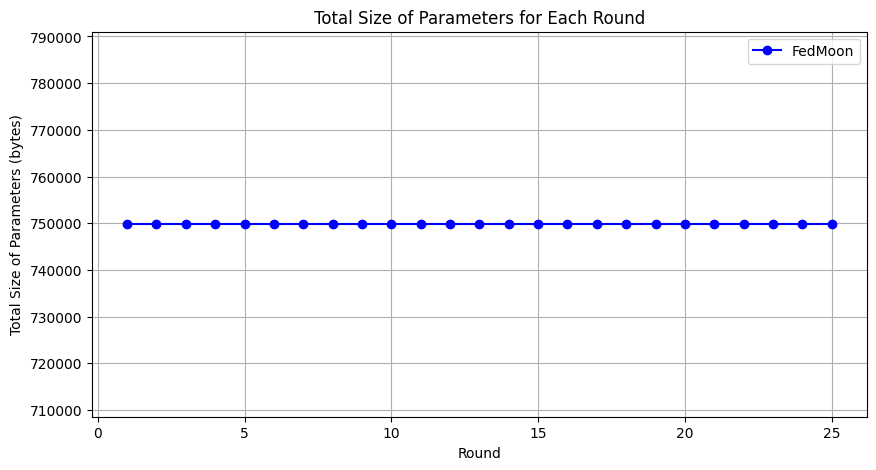

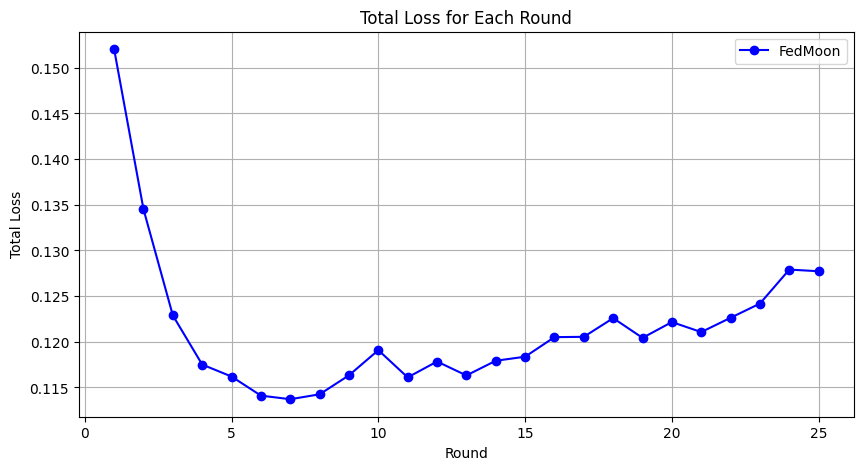

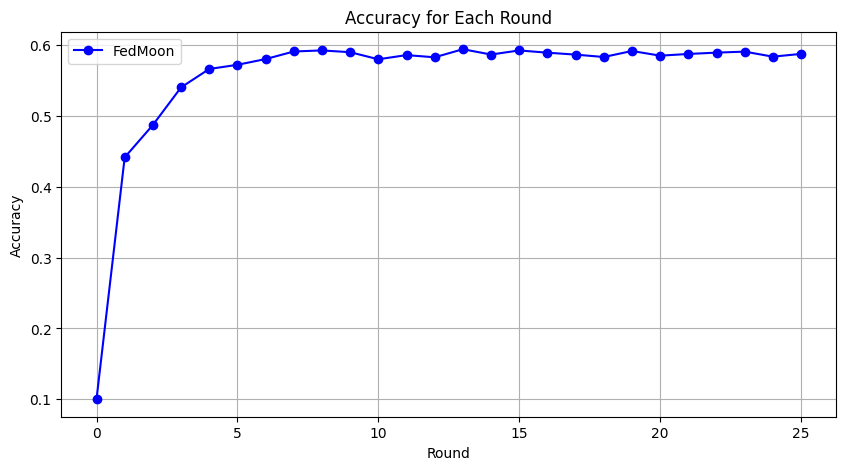

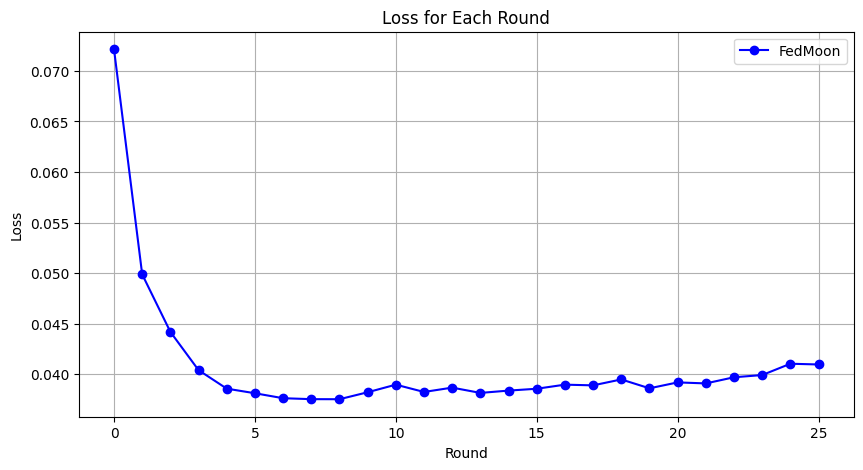

In [21]:
fed_moon_result = fed_avg_result
fed_moon_model_results = fed_avg_model_results

fed_moon_rounds = list(fed_moon_result.keys())
fed_moon_sizes = [fed_moon_result[round]["total_size"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_moon_losses = [fed_moon_result[round]["total_loss"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)

fed_moon_model_rounds = list(fed_moon_model_results.keys())
fed_moon_accuracies = [fed_moon_model_results[round]["global_metrics"]["accuracy"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_moon_global_losses = [fed_moon_model_results[round]["global_loss"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='b', label='FedMoon')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.legend()
plt.grid(True)
